---
title: "2023_Kronensicherung_Plesse_Kraefte_Schwingungen"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Kraefte_Schwingungen

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment) und installiere die Pakete linescale3 (LS3) und treeqinetic (PTQ) inklusive kj_core und kj_logger und weiteren requirements.

## Package Importe

Es werden zuerst benötigte Standard-Pakete importiert. Nachfolgend die zwei extra geschriebenen Pakete LS3 und PTQ. Fehler beim Import dieser zwei Pakete sind ggf. Bugs. Beide Pakete nutzen eine gemeinsame CodeBasis in den Paketen kj_core (Core-Package) und kj_logger (individualisiertes Logging des Verarbeitungs-Prozesses). Diese sollte i. d. R. über die requirements mit installiert werden.

### Import von Standardbibliotheken

Die folgenden Bibliotheken werden importiert, um grundlegende Funktionen für Strukturierung, Datenverarbeitung, Plotting und statistische Auswertung bereit zu stellen.

In [7]:
# Struktur
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc


### Import LineScale3

Das Paket linescale3 wurde vom Autor (Kyell Jensen) zum einfachen Analysieren, Plotten und zur Interpretation der CSV-Messdaten der lineScale3 Kraftmessdose der Firma lineGrip geschrieben (https://www.linegrip.com/linescale-3/). Das Packet ist auf GitHub verfügbar (https://github.com/kyellsen/linescale3). Nachfolgend wird das Packet und einige dort definierten Klassen importiert.

In [8]:
import linescale3 as ls3

# Test
ls3.help()


    Provides detailed guidance on setting up and using the linescale3 package.

    Setup:
        The setup function initializes the linescale3 package with user-defined settings.
        It configures logging, plotting, and the operational environment for data analysis.

        Example Usage:
            config, log_manager, plot_manager = setup('/path/to/directory', 'debug', safe_logs_to_file=True)

    Main Components:
        Series:
            Represents a sequence of measurements.

        Sensor:
            Defines a sensor used in experiments, containing metadata.

        Measurement:
            Represents a single measurement event with associated data and metadata.

    Further Information:
        For detailed API documentation, usage examples, and more, refer to the package documentation or visit the GitHub repository.
    


## Import TreeQinetic

Das Packet TreeQinetic wurde vom Autor (Kyell Jensen) zum einfachen Analysieren, Plotten und zur Interpretation der TXT-Messdaten der Picus TreeQinetic Elastometer und Inclinometer der Firma IML Instrumenta Mechanik Labor Electronic GmbH geschrieben (https://www.iml-electronic.de/produkt/picus-treeqinetic/). Nachfolgend wird das Packet und einige dort definierten Klassen importiert.

In [9]:
import treeqinetic as ptq

# Test
ptq.help()


    Provides detailed guidance on setting up and using the treeqinetic package.

    Setup:
        The setup function initializes the treeqinetic package with user-defined settings.
        It configures logging, plotting, and the operational environment for data analysis.

        Example Usage:
            config, log_manager, plot_manager = setup('/path/to/directory', 'debug', safe_logs_to_file=True)

    Main Components:
        Series:
            Represents a sequence of measurements.

        Sensor:
            Defines a sensor used in experiments, containing metadata.

        Measurement:
            Represents a single measurement event with associated data and metadata.

        Oscillation:
            Represents oscillation data, capturing the dynamic movements in the experiments. Selected from Measurement instance.

    Further Information:
        For detailed API documentation, usage examples, and more, refer to the package documentation or visit the GitHub repositor

## Daten Importe

Lege Pfade für Daten-Importe, Daten-Exporte etc. fest (ggf. anpassen an eigene Verzeichnisstruktur)

In [10]:
# Main
main_path = Path(r"C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse")
analyse_name = r"2023_Kronensicherung_Plesse_Kraefte_Schwingungen"
data_path = Path(r"C:\kyellsen\005_Projekte\2023_Kronensicherung_Plesse\020_Daten")  # Für alle Daten-Importe des Projektes gemeinsam
working_directory = main_path / "030_Analysen" / analyse_name / "working_directory"  # Für alle Daten-Exporte des Projektes gemeinsam


### Lade Metadaten zum Versuch (Baumdaten, Geräteanordnung, Versuchsablauf)

Die Daten wurden während des Versuchs als GoogleSheet erfasst und abschließend als CSV-Dateien exportiert, um ein einfaches Einlesen zur ermöglichen.
Nachfolgend werden Datentypen für alle Spalten explizit angegeben, da es teils durch Python-Pandas zu Fehlerkennungen kommt.
Zusätzlich werden teils Spaltennamen vereinheitlicht und auf Englisch benannt.

#### Daten des Versuchsbaums (tree_df)

Die Tabelle `tree_df` liefert spezifische Informationen über den Versuchsbaum. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table').

In [11]:
dtype_dict = {
    'Attribut': 'string',
    'Wert': 'string',
    'Einheit': 'string'
}
tree_file = data_path / 'tree.csv'
tree_df = pd.read_csv(tree_file,
                      sep=';', decimal=',', na_values='NA',
                      dtype=dtype_dict)
tree_df

,Attribut,Wert,Einheit
0,Art,Fagus silvatica,name
1,HoeheStA,2615,cm
2,HoeheStB,2720,cm
3,Umfang1m,140,cm
4,KS_Laenge,135,cm
5,KS_Hoehe,1740,cm
6,KS_Umfang_StA,58,cm
7,KS_Umfang_StB,48,cm
8,Hoehe_Zwiesel,1031,cm


In [12]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
tree_df_latex = tree_df.copy()
latex_string = tree_df_latex.to_latex(index=False, escape=True, column_format="lrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsbaum}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Versuchsbaum}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsbaum}
    \begin{tabular}{lrr}
\toprule
Attribut & Wert & Einheit \\
\midrule
Art & Fagus silvatica & name \\
HoeheStA & 2615 & cm \\
HoeheStB & 2720 & cm \\
Umfang1m & 140 & cm \\
KS\_Laenge & 135 & cm \\
KS\_Hoehe & 1740 & cm \\
KS\_Umfang\_StA & 58 & cm \\
KS\_Umfang\_StB & 48 & cm \\
Hoehe\_Zwiesel & 1031 & cm \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Versuchsbaum}
\end{table}


#### Daten der Geräteanordnung am Baum (sensor_df)

Die Tabelle `sensor_df` enthält detaillierte Informationen zur Anordnung der Sensoren an den Bäumen im Rahmen des Experiments. Jede Zeile beschreibt die Platzierung eines Sensors. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table_dict').

In [13]:
sensor_position_file = data_path / 'sensor_position.csv'
dtype_dict = {
    'position_id': 'Int64',
    'type': 'category',
    'sensor_id': 'category',
    'location': 'category',
    'height': 'Int64',
    'circumference': 'Int64',
    'direction': 'category',
    'note': 'string'
}
sensor_df = pd.read_csv(sensor_position_file, sep=';', decimal=',', na_values='NA', dtype=dtype_dict)
sensor_df.head()

,position_id,type,sensor_id,location,height,circumference,direction,note
0,1,LS3,14:BF:E6,rope,1830,<NA>,NaN,<NA>
1,2,LS3,14:99:1E,cable,1740,<NA>,NaN,<NA>
2,3,TMS1,015,StA,1800,45,west,<NA>
3,4,TMS1,014,StB,1800,40,west,<NA>
4,5,TMS1,013,StA,1500,67,west,<NA>


In [14]:
#sensor_df.dtypes

In [15]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
sensor_df_latex = sensor_df.copy()[["type", "sensor_id", "location", "direction", "height", "circumference"]]
latex_string = sensor_df_latex.to_latex(index=False, escape=True, column_format="lllrrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Geräteanordnung}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Geräteanordnung}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Geräteanordnung}
    \begin{tabular}{lllrrr}
\toprule
type & sensor\_id & location & direction & height & circumference \\
\midrule
LS3 & 14:BF:E6 & rope & NaN & 1830 & NaN \\
LS3 & 14:99:1E & cable & NaN & 1740 & NaN \\
TMS1 & 015 & StA & west & 1800 & 45 \\
TMS1 & 014 & StB & west & 1800 & 40 \\
TMS1 & 013 & StA & west & 1500 & 67 \\
TMS1 & 012 & StB & west & 1500 & 56 \\
TMS1 & 011 & StA & west & 1200 & 77 \\
TMS1 & 010 & StB & west & 1200 & 76 \\
TMS1 & 007 & StAB & west & 900 & 114 \\
Elasto & 98 & StA & elongation & 1685 & 64 \\
Elasto & 90 & StB & elongation & 1655 & 58 \\
Elasto & 95 & StA & elongation & 1160 & 77 \\
Elasto & 92 & StB & elongation & 1160 & 76 \\
Inclino & 83 & StA & west & 1160 & 77 \\
Inclino & 82 & StB & west & 1160 & 76 \\
Inclino & 81 & Base & west & 0 & NaN \\
Inclino & 85 & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Geräteanordnung}
\end{table}


In [16]:
# Data Dictionary erstellen
data_dict = {
    "Variable": sensor_df_latex.columns.tolist(),
    "Deutsch": ["Typ", "Sensor ID", "Position", "Ausrichtung", "Höhe", "Umfang"],
    "Datentyp": [str(dtype) for dtype in sensor_df_latex.dtypes.tolist()],
    "Einheit": ["-", "-", "-", "-", "cm", "cm"],
    "Beschreibung": ["Typ des Sensors", "ID des Sensors", "Ort am Baum", "Ausrichtung/Himmelsrichtung",
                     "Höhe ü. dem Boden", "Umfang des Stammes am Sensor"]
}

# Dataframe für das Data Dictionary erstellen
data_dict_df = pd.DataFrame(data_dict)
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Geräteanordnung Daten Dokumentation}}
    {latex_string_dict}
    \\label{{tab:Feldversuch_2_Geräteanordnung_Daten_Dokumentation}}
\\end{{table}}
"""
print(latex_table_dict)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Geräteanordnung Daten Dokumentation}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
type & Typ & category & - & Typ des Sensors \\
sensor\_id & Sensor ID & category & - & ID des Sensors \\
location & Position & category & - & Ort am Baum \\
direction & Ausrichtung & category & - & Ausrichtung/Himmelsrichtung \\
height & Höhe & Int64 & cm & Höhe ü. dem Boden \\
circumference & Umfang & Int64 & cm & Umfang des Stammes am Sensor \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Geräteanordnung_Daten_Dokumentation}
\end{table}


#### Daten des Versuchsablaufs (series_df)

Die Tabelle `series_df` enthält das Protokoll des Versuchsablaufes der einzelnen Messungen. Jede Zeile repräsentiert eine einzelne Messung. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table_dict').

##### Behandlungsvariante/Kronensicherung Kategorien

- **`free`**: Der Baum konnte frei ohne Kronensicherung nach dem Release ausschwingen.
  
- **`gefa_dynamic`**: In ca. 2/3 der Baumhöhe wurde ein dynamisches Gefa Gurtband 4t dynamisch nach ZTV-Baumpflege mit leichtem Durchhang installiert. Das Ausschwingen wurde durch die KS abgedämpft. Da die Sicherung ohne Vorspannung installiert wurde, zeigen die Plots (/ls3/plots/force_vs_time_1/) von '14:99:1E' sowohl am Anfang als auch am Ende ca. 0 kN Kraft an (LogNr 1 bis 9).

- **`cobra_static`**: In ca. 2/3 der Baumhöhe wurde eine statische Cobra ultrastatic 7t (Dyneema) Sicherung installiert. Die Vorspannung betrug ca. 0,4 kN, wie sich in den Plots (/ls3/plots/force_vs_time_1/) von '14:99:1E' gut erkennen lässt. Durch das Zusammenziehen der Stämmlinge ist die Kronensicherung vor dem Release vollständig lastfrei (0 kN). Nach dem Release pendelt sich die Kraft ca. bei 0,4 kN ein (LogNr 10-18).

- **`cobra_static_slack`**: Ähnlich der `cobra_static`, jedoch wurde die Vorspannung entfernt. Aufgrund von Regen wurde nur eine Messung durchgeführt und die Serie frühzeitig abgebrochen.


In [17]:
# Series
series_file = data_path / 'series.csv'

# Datentypen für das Einlesen der Daten definieren
series_dtype_dict = {
    'measurement_id': 'Int64',
    'time': 'string',
    'release_force_target': 'float64',
    'treatment': 'category',
    '14:BF:E6': 'Int64',
    '14:99:1E': 'Int64'
}

# CSV-Datei einlesen, Datentypen anwenden, Spalten umbenennen und Datumsformat umwandeln
series_df = pd.read_csv(series_file, sep=';', decimal=',', na_values='NA', dtype=series_dtype_dict)
series_df['time'] = pd.to_datetime(series_df['time'], format="%H:%M:%S").dt.time

from pandas.api.types import CategoricalDtype

# Konvertieren von 'treatment' in eine kategorische Variable mit definierter Reihenfolge
treatment_order = ['free', 'gefa_dynamic', 'cobra_static']
treatment_category = CategoricalDtype(categories=treatment_order, ordered=True)
series_df['treatment'] = series_df['treatment'].astype(treatment_category)

# Ergebnis
series_df.head()

,id,time,release_force_target,treatment,14:BF:E6,14:99:1E
0,1,10:10:00,2.5,free,1,<NA>
1,2,10:20:00,2.8,free,2,<NA>
2,3,10:28:00,2.8,free,3,<NA>
3,4,10:47:00,2.8,free,4,<NA>
4,5,10:53:00,2.4,free,5,<NA>


In [18]:
#series_df.dtypes

In [19]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
series_df_latex = series_df
latex_string = series_df_latex.to_latex(index=False, escape=True, column_format="rrrlrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsablauf}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Versuchsablauf}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsablauf}
    \begin{tabular}{rrrlrr}
\toprule
id & time & release\_force\_target & treatment & 14:BF:E6 & 14:99:1E \\
\midrule
1 & 10:10:00 & 2.50 & free & 1 & NaN \\
2 & 10:20:00 & 2.80 & free & 2 & NaN \\
3 & 10:28:00 & 2.80 & free & 3 & NaN \\
4 & 10:47:00 & 2.80 & free & 4 & NaN \\
5 & 10:53:00 & 2.40 & free & 5 & NaN \\
6 & 11:00:00 & 2.40 & free & 6 & NaN \\
7 & 11:05:00 & 2.40 & free & 7 & NaN \\
8 & 11:10:00 & 2.00 & free & 8 & NaN \\
9 & 11:19:00 & 2.00 & free & 9 & NaN \\
10 & 10:22:00 & 2.00 & free & 10 & NaN \\
11 & 13:30:00 & 2.80 & gefa\_dynamic & 11 & 1 \\
12 & 13:40:00 & 2.80 & gefa\_dynamic & 12 & 2 \\
13 & 13:46:00 & 2.80 & gefa\_dynamic & 13 & 3 \\
14 & 13:57:00 & 2.40 & gefa\_dynamic & 15 & 4 \\
15 & 14:02:00 & 2.40 & gefa\_dynamic & 16 & 5 \\
16 & 14:06:00 & 2.40 & gefa\_dynamic & 17 & 6 \\
17 & 14:10:00 & 2.00 & gefa\_dynamic & 18 & 7 \\
18 & 14:15:00 & 2.00 & gefa\_dynamic & 19 & 8 \\
19 & 14:19

In [20]:
# Data Dictionary erstellen
data_dict = {
    "Variable": series_df_latex.columns.tolist(),
    "Deutsch": ["ID", "Zeit", "Vorspannung", "Behandlungsvar.", "LS3_Zugseil", "LS3_KS"],
    "Datentyp": [str(dtype) for dtype in series_df_latex.dtypes.tolist()],
    "Einheit": ["-", "Zeit", "kN", "-", "-", "-"],
    "Beschreibung": ["ID der Messung", "ca. Uhrzeit Beginn", "F vor Release Zugseil (Soll)", "Behandlung Keine/KS-Typ",
                     "LogNr. LS3 im Zugseil", "LogNr. LS3 in KS"]
}

data_dict_df = pd.DataFrame(data_dict)
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsablauf Daten Dokumentation}}
    {latex_string_dict}
    \\label{{tab:Feldversuch_2_Versuchsablauf_Daten_Dokumentation}}
\\end{{table}}
"""
print(latex_table_dict)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsablauf Daten Dokumentation}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
id & ID & int64 & - & ID der Messung \\
time & Zeit & object & Zeit & ca. Uhrzeit Beginn \\
release\_force\_target & Vorspannung & float64 & kN & F vor Release Zugseil (Soll) \\
treatment & Behandlungsvar. & category & - & Behandlung Keine/KS-Typ \\
14:BF:E6 & LS3\_Zugseil & Int64 & - & LogNr. LS3 im Zugseil \\
14:99:1E & LS3\_KS & Int64 & - & LogNr. LS3 in KS \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Versuchsablauf_Daten_Dokumentation}
\end{table}


### Einlesen der Daten der Kraftmessdosen (Linescale3 Data = LS3)

Die Funktion 'ls3.setup' erstellt Instanzen spezifischer Klassen, die für das Paket notwendig sind (CONFIG, LOG_MANAGER, PLOT_MANAGER). 

Über die Klasse 'ls3.Series' wird eine neue Messreihe initialisiert und als 'ls3_series' gespeichert. Im Verzeichnis 'ls3_data_path' finden sich die Messdaten von zwei lineScale3 ('LS14BFE6' und 'LS14991E').
LS14BFE6: Befand sich während der Messung im Zugseil zwischen den Stämmlingen und erfasste die Vorspannung. Es wurden insgesamt 31 Logs (hier Measurements) aufgezeichnet. Eine Messfrequenz von 40 Hz erschien hier ausreichend.
LS14991E: Befand sich während der Messung in der Kronensicherung und hat die Kraft in der Kronensicherung nach dem Release gemessen. Es wurden 19 Logs erfasst, da die ersten Messungen als Referenz ohne Kronensicherung stattfanden. Hier wurde die maximale Messfrequenz von 1028 Hz gewählt, um Lastspitzen optimal zu erfassen.

In [21]:
ls3.setup(working_directory=working_directory, log_level="info", safe_logs_to_file=True)

ls3_data_path = data_path / 'LS3'
ls3_series = ls3.classes.Series(name=analyse_name, path=ls3_data_path)

2024-11-06 14:21:44 [INFO] kj_logger.update_config: <kj_logger.LogManager object at 0x000002287EFE0A90> initialized - update_config! Code: 000
2024-11-06 14:21:44 [WARNING] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ls3 already exists.
2024-11-06 14:21:44 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ls3!
2024-11-06 14:21:44 [INFO] kj_core.core_config.__init__: <linescale3.config.Config object at 0x000002287FF07C10> initialized! Code: 001
2024-11-06 14:21:44 [INFO] linescale3.setup: ls3: Setup linescale3 package!
2024-11-06 14:21:44 [INFO] kj_core.utils.plot_manager.__init__: <kj_core.utils.plot_manager.PlotManager object at 0x000002287FA82350> initialized! Code: 005

### Einlesen der Daten der Elastometer (PicusTreeQinetic Data = PTQ)

Aus dem Zugversuchsset wurden 4 Elastometer und 3 Inclinometer verwendet.

Die Elastometer waren auf dem rechten und linken Stämmling auf der Außenseite in zwei Ebenen platziert. Beim Zusammenziehen der Stämmlinge messen diese entsprechnd eine Faserdehnung, beim Ausschwingen der Stämmlinge über ihre Ruhelage hinaus nach außen eine Faserstauchung.

Die Inclinometer Daten werden hier ebefalls geladen, erschienen aber weniger geeignet zur Auswertung und werden entspricht nicht weiter berücksichtigt.

Die Funktion 'ptq.setup' erstellt div. Instanzen, die für das Paket notwendig sind (CONFIG, LOG_MANAGER, PLOT_MANAGER). 

Über die Klasse 'ptq.Series' wird eine neue Messreihe initialisiert und als 'ptq_series' gespeichert. Im Verzeichnis ptq_data_path finden sich die PTQ Daten als TXT von insgesamt 29 Messungen. Eine Datei enthält jeweils die Daten für alle Inclinometer und Elastometer.

In [22]:
ptq.setup(working_directory=working_directory, log_level="info", safe_logs_to_file=True)

ptq_data_path = data_path / 'PTQ/data_txt'
ptq_series = ptq.classes.Series(name=analyse_name, path=ptq_data_path)

elasto_names = ["Elasto(95)", "Elasto(98)", "Elasto(92)", "Elasto(90)"]

2024-11-06 14:21:46 [INFO] kj_logger.update_config: <kj_logger.LogManager object at 0x000002287EFE0A90> initialized - update_config! Code: 000
2024-11-06 14:21:46 [WARNING] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ptq already exists.
2024-11-06 14:21:46 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ptq!
2024-11-06 14:21:46 [INFO] kj_core.core_config.__init__: <treeqinetic.config.Config object at 0x000002287EFE0B50> initialized! Code: 001
2024-11-06 14:21:46 [INFO] treeqinetic.setup: ptq: Setup treeqinetic package!
2024-11-06 14:21:46 [INFO] kj_core.utils.plot_manager.__init__: <kj_core.utils.plot_manager.PlotManager object at 0x000002287FAA60D0> initialized! Code: 

## Datenanalyse LS3 und PTQ getrennt

Da teilweise für jede Messung und jeden Sensor ein Plot generiert wird, werden diese nicht im Notebook direkt angezeigt, sondern im Explorer gespeichert. Die Plots liegen entsprechend im working_directory in den Verzeichnissen ls3/plots/ bzw. ptq/plots.

### LS3: Erster Blick

'ls3_series.plot_force_vs_time' erstellt für jede Messung für beide eingesetzten LineScales einen Plot, in dem die ermittelte Kraft (force in kN) gegenüber der Zeit (sec_since_start) abgebildet wird. Die Plots werden im Verzeichnis 'ls3/plots/force_vs_time_1/' abgelegt.

14:BF:E6: Hat die tatsächliche Vorspannung ermittelt und hat entsprechend für alle 29 (-2) Messungen (experiment_id) einen Log aufgezeichnet.
Aufgrund der Messtechnik wurden 2 Logs erstellt, die keine Messung darstellen. Diese dürfen nicht mit ausgewertet werden (Measurement ID 14 und 30).

14:99:1E: Hat die Lasten in der Kronensicherung aufgezeichnet und hat entsprechend nur für die 19 (-1) Messungen mit Kronensicherungen einen Log aufgezeichent.

In [23]:
#ls3_series.plot_force_vs_time()

In [24]:
ls3_series.plot_force_vs_time_with_max_and_release()

2024-11-06 14:21:48 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '1', name: '14991E_23_03_22_14_41_10', sensor_id: '14:99:1E')'.
2024-11-06 14:21:49 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '2', name: '14991E_23_03_22_14_47_59', sensor_id: '14:99:1E')'.
2024-11-06 14:21:49 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '3', name: '14991E_23_03_22_14_55_03', sensor_id: '14:99:1E')'.
2024-11-06 14:21:50 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '4', name: '14991E_23_03_22_15_04_05', sensor_id: '14:99:1E')'.
2024-11-06 14:21:50 [INFO] linescale3.classes.measur

### LS3: Metadata DataFrame

'ls3_series.metadata_df' enthält für jeden Log (measurement_id) der 2 LineScales die Metadaten der Messung.

Parameter / Einstellung LineScale für Messung:
- `datetime`: Startzeitpunkt der Messung
- `measurement_id`: LogNr
- `unit`: Einheit für Kraft
- `mode`: ABS für absolute Kraft
- `rel_zero`: Für ABS-Modus nicht relevant
- `speed`: Messgeschwindigkeit in Hz
- `trig`: Mindestkraft für Messbeginn in kN
- `stop`: Stop Messung bei Kraft-Unterschreitung (hier feste Zeitspanne für Messung)
- `pre`: Zeitraum, der vor dem trigger-zeitpunkt nachträglich ergänzt wird (in Sekunden)
- `catch`: Zu erfassender Zeitraum (in Sekunden)
- `total`: Gesamter Messzeitraum

Korrekturfaktor:
- `timing_correction_factor`: Die Auswertung zeigt, dass im LineScale die Zeit ca. mit dem Faktor 0.9 falsch erfasst wird. Die tatsächliche Abtastrate, Duration etc. wird entsprechend korrigiert.

Berechnete Parameter:
- `datetime_start`: Startzeitpunkt der Messung
- `datetime_end`: Endzeitpunkt der Messung
- `duration`: Dauer der Messung
- `length`: Anzahl der erfassten Messpunkte
- `max`: Index und Wert der maximalen Kraft in kN
- `mean`: arithmetisches Mittel der Kraft
- `median`: median der Kraft
- `min`: Index und Wert der minmalen Kraft in kN
- `release`: Für jeden Log von 14:BF:E6 (LineScale zur Messung der Vorspannung) wurde die Kraft in kN ermittelt, die kurz vor dem Release vorlag. Diese Kraft ist in den Plots (/ls3/plots/force_vs_time_1/) als grüne Linie markiert. Die entsprechende Funktion befindet sich in 'ls3/classes/measurement.py' und heißt 'get_release_force'.

Anmerkung zu get_release_force: Die Funktion filtert alle Kraftwerte über 1.0 kN (Parameter min_force=1.0). Innerhalb der gefilterten Werte wird ein Bereich ausgewählt, der 3 Sekunden vor dem Ende der Messung endet (Parameter distance_to_end_sec=3) und insgesamt 5 Sekunden lang ist (Parameter window_sec=5). Für diesen Zeitraum wird der Mittelwert (Mean) berechnet. Die release_force ist somit der Mittelwert eines 5-sekündigen Plateaus vor dem Release und wird nicht durch kurzzeitige Lastspitzen im Zugseil verfälscht.

In [25]:
ls3_metadata_df = ls3_series.metadata_df
ls3_metadata_df.head()

,measurement_name,sensor_id,datetime,measurement_id,unit,mode,rel_zero,speed,trig,stop,...,timing_correction_factor,datetime_start,datetime_end,duration,length,max,mean,median,min,release
0,14991E_23_03_22_14_41_10,14:99:1E,2022-03-23 14:41:10,1,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:41:10,2022-03-23 14:41:26.199296875,16.199296,23040,"(4737, 1.48)",0.111598,0.06,"(36, 0.0)",NaN
1,14991E_23_03_22_14_47_59,14:99:1E,2022-03-23 14:47:59,2,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:47:59,2022-03-23 14:48:15.199296875,16.199296,23040,"(4721, 1.44)",0.117817,0.06,"(135, 0.0)",NaN
2,14991E_23_03_22_14_55_03,14:99:1E,2022-03-23 14:55:03,3,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:55:03,2022-03-23 14:55:19.199296875,16.199296,23040,"(3867, 1.33)",0.104375,0.06,"(81, 0.0)",NaN
3,14991E_23_03_22_15_04_05,14:99:1E,2022-03-23 15:04:05,4,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 15:04:05,2022-03-23 15:04:21.199296875,16.199296,23040,"(3861, 1.01)",0.072250,0.04,"(49, -0.01)",NaN
4,14991E_23_03_22_15_08_55,14:99:1E,2022-03-23 15:08:55,5,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 15:08:55,2022-03-23 15:09:11.199296875,16.199296,23040,"(4730, 1.16)",0.108828,0.06,"(73, 0.0)",NaN


### PTQ: Erster Blick

Übersicht über alle vom PTQ erfassten Daten über alle Messungen gemeinsam (Elastos und Inclinos).

In [26]:
ptq_df = ptq_series.get_measurements_df()
ptq_df#.describe()

,ID,Nr,Datetime,Sec_Since_Start,Elasto(98),Elasto(95),Elasto(92),Elasto(90),Inclino(85)X,Inclino(85)Y,Inclino(83)X,Inclino(83)Y,Inclino(82)X,Inclino(82)Y,Inclino(81)X,Inclino(81)Y
0,1,0,2023-03-22 10:10:39.830198,0.000,NaN,-10.8,2.2,14.2,0.187,0.0,-0.180,-0.036,-0.055,0.061,-0.004,-0.004
1,1,1,2023-03-22 10:10:40.089198,0.259,-3.7,-11.1,3.1,14.7,0.174,0.0,-0.195,-0.017,-0.066,0.051,-0.002,-0.004
2,1,2,2023-03-22 10:10:40.329198,0.499,-4.3,-11.4,2.6,15.2,0.161,0.0,-0.205,0.016,-0.074,0.057,0.000,-0.003
3,1,3,2023-03-22 10:10:40.575198,0.745,-5.8,-11.5,3.3,15.5,0.123,0.0,-0.207,0.054,-0.082,0.077,-0.001,-0.006
4,1,4,2023-03-22 10:10:40.817198,0.987,-5.9,-11.8,3.4,15.5,0.098,0.0,-0.204,0.096,-0.087,0.101,-0.001,-0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17831,29,559,2023-03-22 16:12:54.492613,198.481,-0.7,-0.9,-7.3,-15.9,0.149,0.0,0.527,0.112,0.030,0.122,0.008,-0.002
17832,29,560,2023-03-22 16:12:54.734613,198.723,-0.4,-0.5,-8.0,-16.3,0.039,0.0,0.546,0.018,0.051,0.062,-0.001,-0.002
17833,29,561,2023-03-22 16:12:54.974613,198.963,-0.1,0.0,-8.2,-16.4,0.071,0.0,0.563,-0.070,0.071,0.006,0.000,-0.002
17834,29,562,2023-03-22 16:12:55.214613,199.203,0.2,0.7,-9.0,-16.3,0.151,0.0,0.579,-0.122,0.095,-0.042,-0.002,0.001


#### Einhaltung der maximalen Faserdehnung/-Stauchung

In [327]:
ptq_df_elasto_summary = ptq_df[elasto_names].describe()
ptq_df_elasto_summary

,Elasto(95),Elasto(98),Elasto(92),Elasto(90)
count,17468.000000,17461.000000,17657.000000,17676.000000
mean,105.786833,81.627536,118.740437,191.147720
std,89.518611,64.555211,101.978415,157.750503
min,-119.100000,-192.900000,-111.000000,-217.800000
25%,8.400000,16.900000,5.700000,13.475000
50%,128.500000,95.100000,139.500000,235.850000
75%,184.700000,137.500000,213.100000,337.600000
max,266.300000,234.600000,291.500000,429.600000


Analyse maximaler Dehnung und Stauchung, Prüfung auf Einhaltung der Elastizitätsgrenze (Fagus s. ca. 520 µm über 200~mm Länge des Elastos).

In [28]:
ptq_df_elasto_min_max = ptq_df_elasto_summary.loc[['min', 'max']]
ptq_df_elasto_min_max

,Elasto(95),Elasto(98),Elasto(92),Elasto(90)
min,-119.1,-192.9,-111.0,-217.8
max,266.3,234.6,291.5,429.6


In [29]:
latex_string = ptq_df_elasto_min_max.to_latex(index=True, escape=True, column_format="lrrrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Maximale Dehnungswerte der Elastometer in µm, erfasst über alle Messungen}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Elasto_Max}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Maximale Dehnungswerte der Elastometer in µm, erfasst über alle Messungen}
    \begin{tabular}{lrrrr}
\toprule
 & Elasto(95) & Elasto(98) & Elasto(92) & Elasto(90) \\
\midrule
min & -119.10 & -192.90 & -111.00 & -217.80 \\
max & 266.30 & 234.60 & 291.50 & 429.60 \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Elasto_Max}
\end{table}


Die maximalen Dehnungs- und Stauchungswerte der Elastos innerhalb jeder Messung werden bei der Gesamtauswertung später verwendet.

In [30]:
# Gruppiere nach ID und berechne min und max für jede Elasto-Spalte
ptq_df_elasto_min_max = ptq_df.groupby('ID')[elasto_names].agg(['min', 'max'])
#ptq_df_elasto_min_max

In [31]:
latex_string = ptq_df_elasto_min_max.reset_index().to_latex(index=False, escape=True, column_format="lrrrrrrrr", float_format="{:0.0f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Maximalwerte Elastometer vollständig, Stauchung-/Dehunung in µm über 200~mm Länge Messgerät}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Elasto_Max_vollständig}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Maximalwerte Elastometer vollständig, Stauchung-/Dehunung in µm über 200~mm Länge Messgerät}
    \begin{tabular}{lrrrrrrrr}
\toprule
ID & \multicolumn{2}{r}{Elasto(95)} & \multicolumn{2}{r}{Elasto(98)} & \multicolumn{2}{r}{Elasto(92)} & \multicolumn{2}{r}{Elasto(90)} \\
 & min & max & min & max & min & max & min & max \\
\midrule
1 & -119 & 215 & -133 & 193 & -87 & 241 & -168 & 368 \\
2 & -90 & 254 & -94 & 208 & -111 & 283 & -202 & 430 \\
3 & -107 & 262 & -139 & 194 & -87 & 292 & -180 & 428 \\
4 & -116 & 250 & -161 & 172 & -110 & 267 & -218 & 402 \\
5 & -71 & 237 & -114 & 196 & -94 & 252 & -187 & 386 \\
6 & -112 & 198 & -167 & 146 & -99 & 231 & -203 & 345 \\
7 & -111 & 240 & -158 & 192 & -101 & 229 & -207 & 344 \\
8 & -95 & 180 & -141 & 154 & -88 & 208 & -181 & 321 \\
9 & -102 & 202 & -134 & 165 & -89 & 203 & -181 & 315 \\
10 & -109 & 187 & -157 & 129 & -81 & 208 & -176 & 313 \\
11 & -64 & 221 & -158 & 159 & -51 & 244 & -210

#### Plotten aller Messungen bzw. Elastometer

Plotten der 4 verwendeten Elastometer in einem Plot für jede Messung. Die Plots werden im Verzeichnis ptq/plots/multi_sensors_vs_time_1/ abgelegt.
Für alle Messungen und Elastometer ist gut zu erkennen, wie die Faserdehnung während des zusammen ziehen der Stämmlinge zunimmt, dann im Moment des Realises plötzlich abfällt, um in Folge harmonisch gedämpft auszuschwingen (nährungsweise).

In [32]:
ptq_series.plot_measurement_sensors(sensor_names=elasto_names)

2024-11-06 14:22:13 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'' successful.
2024-11-06 14:22:14 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'' successful.
2024-11-06 14:22:14 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_102314.txt', ID: 3, Start '2023-03-22 10:26:25.086505' to '2023-03-22 10:28:50.847505'' successful.
2024-11-06 14:22:15 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_104400.txt', ID: 4, Start '2023-03-22 10:50:02.131987' to '2023-03-22 10:52:43.662987'' successful.
2024-11-06 14:22:15 [INFO] treeqinetic.class

### PTQ: Schwingungsbereiche selektieren

Selektiere die Bereiche nach dem Release, bei dem es zu einer harmonisch gedämpften Schwingung kommt. Die Methode Series.get_oscillations sucht im Standardfall nach einem Bereich in den Messdaten mit einer Länge von 20 Sekunden. Der Anfangszeitpunkt wird durch einen plötzlichen Abfall der Dehnung auf unter Null bestimmt, bei dem die Steigung mindestens -25 beträgt. Die Suche nach dem Startzeitpunkt beginnt erst 60 Sekunden nach Messungsbeginn. Der entsprechende Code befindet sich im Paket classes/measurement.py und utils/select_oscillation.py. Die so isolierten Bereiche werden als Instanzen der Klasse Oscillation initialisiert. Weitere Parameter wie Amplitude, Frequenz und Dämpfung werden direkt berechnet.
Parameter:
- sensor_names: Eine Liste der Sensornamen, für die die Schwingungsdaten identifiziert werden sollen.
- min_time_default: Die Mindestzeitspanne nach Beginn der Messung, nach der die Suche nach Schwingungen beginnt (Standard: 60 Sekunden).
- min_value: Der minimale Wertschwellenwert, damit Sensordaten als gültig betrachtet werden.
- threshold_slope: Der Steigungsschwellenwert, um den Beginn einer Schwingung zu bestimmen.
- duration: Die Dauer, für die die Schwingungsdaten extrahiert werden sollen.

In [33]:
ptq_series.get_oscillations(
    sensor_names=elasto_names,
    min_time_default=60,
    min_value=50,
    threshold_slope=-50,
    duration=17.5
)

2024-11-06 14:22:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'
2024-11-06 14:22:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'
2024-11-06 14:22:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_102314.txt', ID: 3, Start '2023-03-22 10:26:25.086505' to '2023-03-22 10:28:50.847505'
2024-11-06 14:22:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_104400.txt', ID: 4, Start '2023-03-22 10:50:02.131987' to '2023-03-22 10:52:43.662987'
2024-11-06 14:22:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_105549.txt', ID: 5, Start '2023-03-22 10:55:59.

#### PTQ: Selektion Oscillation prüfen in Plots

Plotten der relevanten Sensoren bzw. der selektierten Bereiche. Die Plots werden im Verzeichnis ptq/plots/select_oscillations_single/ bzw. ptq/plots/select_oscillations_combined/ gespeichert. In einem Combined-Plot werden alle 4 Elastometer einer Messung gemeinsam dargestellt. Hier wird manuell anhand der Plots geprüft, ob für alle Messungen und Sensoren der richtige Bereich ausgewählt wurde.

In [34]:
#ptq_series.plot_oscillations_for_measurements(sensor_names=elasto_names, combined=False)
#ptq_series.plot_oscillations_for_measurements(sensor_names=elasto_names, combined=True)

### PTQ: Liste aller Oscillation-Instanzen, Plotting

Aus der PTQ-Messreihe 'ptq_series' wird über get_oscillations_list für alle Messungen getrennt für jeden Sensor (Elastometer) die Oscillation-Instanze in eine Liste zusammengeführt. Entsprechend gibt es für jede PTQ-Messung 4 Oscillation Instanzen (4 Elastometer).

'oscillation.fit' fitted alle Oscillationen mit einer allgemeinen Funktion für harmonisch gedämpfte Schwingungen 
$$
f(t) = A \cdot e^{-\beta t} \cdot \cos(2 \pi \omega t + \phi) + y_0
$$
Parameterbeschreibung:
- `A` (Anfangsamplitude): Der Anfangswert der Amplitude der Schwingung. Dieser Parameter bestimmt die initiale Höhe der Schwingungsamplitude.
- `β` (Dämpfungskoeffizient): Dieser Wert bestimmt, wie schnell die Amplitude der Schwingung mit der Zeit abnimmt. Ein höherer Wert führt zu einer schnelleren Dämpfung der Schwingung.
- `ω` (Winkelfrequenz): Die Frequenz der Schwingung. Dieser Parameter bestimmt, wie schnell die Schwingung oszilliert.
- `φ` (Phasenwinkel): Der Anfangsphasenwinkel der Schwingung. Dieser Wert bestimmt den Startpunkt der Schwingung im Schwingungszyklus.
- `y_0` (Vertikale Verschiebung): Dieser Parameter verschiebt die gesamte Schwingungskurve vertikal und ermöglicht es, die Schwingung an die mittlere Position der Daten anzupassen.
- `x_0` (Horizontale Verschiebung): Dieser Parameter verschiebt die gesamte Schwingungskurve horizontal über die Zeit und ermöglicht es, die Schwingung an die mittlere Position der Daten anzupassen.

(siehe `ptq/analyse/fitting_function.py')
        
Zusätzliche Parameter und Konfigurationen:

- `Startwerte und Grenzwerte`: Für die Optimierung der Parameter in `scipy.curve_fit` werden Startwerte und Grenzwerte für jeden Parameter übergeben (in`ptq/config.py` definiert).
- `Qualitätsmetriken`: Zur Bewertung der Anpassungsgüte werden vier Metriken verwendet: MSE (mittlerer quadratischer Fehler), MAE (mittlerer absoluter Fehler), RMSE (Root Mean Square Error) und \( R^2 \) (Bestimmtheitsmaß).
- `Warnungen bei Überschreitung der Grenzwerte`: Wenn die für eine Metrik definierten Grenzwerte überschritten werden, wird eine Warnung im Log-Protokoll vermerkt, um auf mögliche Probleme bei der Anpassung hinzuweisen (in`ptq/config.py` definiert). Auf Basis dieser Warnung können A) Start-, Grenzwerte und Methodik angepasst werden und B) die ermittelten Werte später Wirksam gefiltert werden, um schlecht angepasste Messungen bzw. Sensoren auszuschließen.
- `interpolate`: Diese Option aktiviert die Interpolation der Datenpunkte, um eine ausreichende Dichte für `curve_fit` zu gewährleisten. Hierbei wird `scipy.interpolate.PchipInterpolator` verwendet, um Über- und Unterschwingungen, die nicht in den Originaldaten vorhanden sind, zu vermeiden. Die Ergebnisse liefen nach optischer Prüfung verlässlichere Ergebnisse als z. B. kubische Interpolation o.ä.
- `clean_peaks`: Diese Funktion bereinigt die Datenserie, indem sie inkonsistente Werte zwischen identifizierten Spitzen (Peaks) und Tälern (Valleys) entfernt. Dadurch kann die Anpassung und Analyse verbessert werden, da die Rohdaten dadurch bereits harmonischer Schwingen. Nachteil: Manipulation der Originaldaten bzw. Entfernung von Messwerten, die sich schlecht durch eine harmonisch gedämpfte Schwingung beschreiben lassen, in realität aber gemessen wurden.

Visualisierungsoptionen:

- `plot`: Wenn auf `True` gesetzt, wird für jede Oscillation ein Plot der angepassten Funktion zusammen mit den Originaldaten erstellt und in `working_dir/PTQ/plots/` gespeichert.

- `plot_error`: Wenn auf `True` gesetzt, wird ein Histogramm der Fehlerverteilung für jeden Fit erstellt und ebenfalls in `working_dir/PTQ/plots/` gespeichert.

In [35]:
ptq_oscillations_ls = ptq_series.get_oscillations_list()

initial_param = {
    "initial_amplitude": 170,
    "damping_coeff": 0.32,
    "angular_frequency": 0.44,
    "phase_angle": 0,
    "y_shift": 0,
    "x_shift": 0
}

param_bounds = {
    "initial_amplitude": (150, 250),
    "damping_coeff": (0.1, 1),
    "angular_frequency": (0.35, 0.58),
    "phase_angle": (-0.2, 0.2),
    "y_shift": (-60, 60),
    "x_shift": (-0.25, 0.75),
}

metrics_warning = {
    "pearson_r": (0.75, 1),
    "nrmse": (0, np.inf),
    "mae": (0, np.inf),
    "nmae": (0, 0.10)
}

for oscillation in ptq_oscillations_ls:
    oscillation.fit(initial_param, param_bounds, optimize_criterion="mae", metrics_warning=metrics_warning, plot=False,
                    plot_error=False, dir_add="", interpolate=True)

2024-11-06 14:22:30 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(95)'' successful.
2024-11-06 14:22:33 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(98)'' successful.
2024-11-06 14:22:35 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(92)'' successful.
2024-11-06 14:22:38 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(90)'' successful.
2024-11-06 14:22:41 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_101814.txt', ID: 2, Sensor: Elasto(95)'' successful.
2024-11-06 14:22:44 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_101814.txt', ID: 2, Sensor: Elasto(98)'' successful.
2024-11-06 14:22:46 [INFO] t

#### Fehlerverteilung der Funktionsanpassung an Messdaten

Die Funktion sammelt für alle Oscillation-Objekte die Fehler-Arrays der Anpassung und normalisiert die Fehler (um Unterschiede in der Skalierung zu entfernen).
Anschließend werden die Fehler für alle Messungen A) für alle Sensoren gemeinsam und B) getrennt für jeden Sensor geplotet. Es werden Q-Q-Plot, Violin-Plot und Histogramme für den gleichen Sachverhalt erstellt und in `working_directory\PTQ\plots\series_osc_errors` abgelegt.

- `trim_hist_percent`: Beschneidet die Daten Links und Rechts um die äußersten x Prozent, da die Verteilung im Zentrum sonst kaum zu bewerten ist. Wirkt sich nur auf die Histogramme aus.

In [251]:
#all_normalized_errors = ptq_series.plot_osc_errors(plot_qq=True, plot_violin=True, plot_hist=True, hist_trim_percent=2)


### PTQ: Zusammenfassung der Schwingungsparameter aller Oscillations als DataFrame

'ptq_series.get_oscillations_df' fasst aus allen Oscillation-Instanzen der Messreihe ('ptq_series') die Schwingungsparameter als pandas.DataFrame zusammen

In [252]:
ptq_metadata_df = ptq_series.get_oscillations_df()
# Converting 'sensor_name' to categorical
ptq_metadata_df['sensor_name'] = ptq_metadata_df['sensor_name'].astype('category')

metrics_warning_count = ptq_metadata_df['metrics_warning'].sum()
print(f"metrics_warning_count: {metrics_warning_count}")
#ptq_metadata_df

metrics_warning_count: 9


In [253]:
ptq_metadata_df = ptq_metadata_df.drop(
    ['file_name', 'sample_rate', 'metrics_warning', 'max_value', 'min_value', 'p_value', 'r2', 'mse', 'rmse', 'cv',
     'mae', 'phase_angle', 'x_shift'], axis=1)
ptq_metadata_df.describe()

,id,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,angular_frequency,y_shift,pearson_r,nrmse,nmae
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,15.000000,163.335345,84.369828,169.645807,0.422633,0.455732,-5.402632,0.888799,0.053127,0.029251
std,8.402898,56.904815,43.679152,10.796269,0.266001,0.039568,15.803827,0.084400,0.017789,0.009189
min,1.000000,81.900000,10.450000,150.000000,0.152005,0.350000,-44.362167,0.577722,0.024961,0.014277
25%,8.000000,125.650000,46.087500,169.476443,0.248172,0.437313,-15.328379,0.853768,0.040790,0.021926
50%,15.000000,144.650000,87.950000,169.864032,0.339948,0.447801,-4.467251,0.919387,0.049523,0.028352
75%,22.000000,193.050000,112.075000,170.039285,0.453138,0.457109,1.484971,0.943763,0.064283,0.034944
max,29.000000,309.850000,178.350000,250.000000,1.000000,0.547856,55.799393,0.987644,0.152001,0.062792


## Zusammenführen der Daten von LS3, PTQ und Versuchsprotokoll

### Auswahl und Vorbereitung der Daten

Definition relevanter Spalten aus ls3_metadata_df und Anpassung der Datenstruktur, um nur die erforderlichen Variablen abzufragen. 

In [254]:
# Selecting relevant columns and creating a copy to avoid SettingWithCopyWarning
select_cols = ['sensor_id', 'measurement_id', 'max', 'release']
ls3_metadata_df = ls3_metadata_df[select_cols].copy()

# Extracting values from tuples in 'max'
ls3_metadata_df['max'] = ls3_metadata_df['max'].apply(lambda x: x[1] if isinstance(x, tuple) else x)

Die Spalten aus ptq_metadata_df werden mit einem Präfix versehen, um eine klare Unterscheidung zu ermöglichen. Hier sind die Metdadaten der Oscillations enthalten.

In [255]:
# Adding prefix to columns in ptq_metadata_df except 'id'
# List of all columns except 'id'
columns_to_prefix = ptq_metadata_df.columns.difference(['id'])
# Add the prefix 'ptq_' to these columns
ptq_metadata_df.rename(columns={col: 'ptq_' + col for col in columns_to_prefix}, inplace=True)
ptq_metadata_df.head(3)

,id,ptq_sensor_name,ptq_m_amplitude,ptq_m_amplitude_2,ptq_initial_amplitude,ptq_damping_coeff,ptq_angular_frequency,ptq_y_shift,ptq_pearson_r,ptq_nrmse,ptq_nmae
0,1,Elasto(95),154.65,82.25,170.297574,0.283248,0.437321,-30.993007,0.932709,0.048022,0.026888
1,1,Elasto(98),137.20,92.50,170.139165,0.239312,0.442781,-21.696724,0.979672,0.029934,0.020370
2,1,Elasto(92),163.25,76.00,169.680935,0.280936,0.436629,-11.374560,0.931204,0.040776,0.020856


Die maximalen Dehnungs- und Stauchungswerte der Elastometer werden in der Struktur angepasst, um sie mit den weiteren Daten zusammenzuführen.

In [256]:
ptq_df_elasto = ptq_df_elasto_min_max.stack(level=0).reset_index()

ptq_df_elasto = ptq_df_elasto.rename(columns={
    'ID': 'id', 
    'level_1': 'ptq_sensor_name',
    'max': 'ptq_max_elongation',
    'min': 'ptq_max_compression'
})

ptq_df_elasto.head(3)

C:\Users\mail\AppData\Local\Temp\ipykernel_26288\2961389627.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ptq_df_elasto = ptq_df_elasto_min_max.stack(level=0).reset_index()


,id,ptq_sensor_name,ptq_max_compression,ptq_max_elongation
0,1,Elasto(90),-168.1,368.0
1,1,Elasto(92),-86.6,240.9
2,1,Elasto(95),-119.1,215.0


### Zusammenführen

Integration verschiedener Datenquellen in einen einheitlichen DataFrame durch sukzessives Zusammenführen (merge).

In [257]:
# Merging ptq_metadata_df and ptq_df_elasto
df = pd.merge(ptq_metadata_df, ptq_df_elasto, on=['id', 'ptq_sensor_name'], how='left')

In [258]:
# Merging new df (ptq_metadata_df+ptq_df_elasto) and series_df
df = pd.merge(df, series_df, on='id', how='left')

In [259]:
# Merging df and elasto_df
# Filter sensor_df for 'Elasto' type
elasto_df= sensor_df[sensor_df["type"] == "Elasto"].copy()

# Create the ptq_sensor_name formatted column
elasto_df["ptq_sensor_name"] = elasto_df["type"].astype(str) + "(" + elasto_df["sensor_id"].astype(str) + ")"

elasto_df['diameter'] = elasto_df['circumference'] / np.pi

# Define the specific columns to keep before merging
select_cols = ["ptq_sensor_name", "location", "height", "diameter", "direction"]

# Filter and keep only the selected columns in elasto_df
elasto_df = elasto_df[select_cols]

# Perform the left join on ptq_sensor_name
df = df.merge(elasto_df, on="ptq_sensor_name", how="left")

In [260]:
# Function to prepare ls3_metadata
def prepare_ls3_metadata(df, sensor_id, new_prefix):
    return (df.query(f"sensor_id == '{sensor_id}'")
            .drop('sensor_id', axis=1)
            .add_prefix(new_prefix)
            .rename(columns={f'{new_prefix}measurement_id': sensor_id}))
# Merging ls3_metadata with the main DataFrame
df = df.merge(prepare_ls3_metadata(ls3_metadata_df, '14:BF:E6', 'ls3_rope_'), on='14:BF:E6', how='left')     
df = df.merge(prepare_ls3_metadata(ls3_metadata_df, '14:99:1E', 'ls3_cable_'), on='14:99:1E', how='left')     


In [261]:
df.to_csv(working_directory / 'export/df_2.csv', index=False)

## Datenbereinigung und Kategorisierung

Filterung und Kategorisierung der Daten für weitergehende Analysen.

### Filtern der relevanten Messungen aus Versuchsprotokoll

Messung id = 1 war eine Vorabtest des Versuchsaufbaus und wurde mit einer unregelmäßigen Vorspannung von 2.5 durchgeführt.
Messung id = 29 war der einzige Versuch mit der Behandlung cobra_static_slack.
Die entsprechenden 2 Messungen werden entfernt.

In [262]:
# filtering and cleaning 
df = (df.drop(['14:BF:E6', '14:99:1E', 'ls3_cable_release', 'ls3_rope_max', 'time'], axis=1)
      .query("release_force_target in [2.0, 2.4, 2.8] and treatment in ['free', 'gefa_dynamic', 'cobra_static']"))

# Sortieren des DataFrames nach der 'treatment'-Spalte
df_sorted = df.sort_values(by='treatment')
df.head()

,id,ptq_sensor_name,ptq_m_amplitude,ptq_m_amplitude_2,ptq_initial_amplitude,ptq_damping_coeff,ptq_angular_frequency,ptq_y_shift,ptq_pearson_r,ptq_nrmse,...,ptq_max_compression,ptq_max_elongation,release_force_target,treatment,location,height,diameter,direction,ls3_rope_release,ls3_cable_max
4,2,Elasto(95),158.65,82.05,169.477340,0.348224,0.422702,-19.011253,0.908058,0.044873,...,-90.4,254.4,2.8,free,StA,1160,24.509861,elongation,2.72310,NaN
5,2,Elasto(98),134.65,91.35,169.982423,0.294159,0.443529,-1.099515,0.980663,0.029621,...,-93.8,207.9,2.8,free,StA,1685,20.371833,elongation,2.72310,NaN
6,2,Elasto(92),191.30,79.55,169.752879,0.377778,0.432441,-14.233643,0.929554,0.034560,...,-111.0,282.6,2.8,free,StB,1160,24.191551,elongation,2.72310,NaN
7,2,Elasto(90),309.85,162.95,170.628807,0.222522,0.441518,-5.287164,0.943158,0.038866,...,-202.2,429.6,2.8,free,StB,1655,18.461973,elongation,2.72310,NaN
8,3,Elasto(95),173.95,94.50,169.860215,0.269471,0.436023,-3.785755,0.938307,0.039020,...,-106.8,262.2,2.8,free,StA,1160,24.509861,elongation,2.76205,NaN


In [263]:
df.describe()

,id,ptq_m_amplitude,ptq_m_amplitude_2,ptq_initial_amplitude,ptq_damping_coeff,ptq_angular_frequency,ptq_y_shift,ptq_pearson_r,ptq_nrmse,ptq_nmae,ptq_max_compression,ptq_max_elongation,release_force_target,height,diameter,ls3_rope_release,ls3_cable_max
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.0,108.0,108.000000,72.000000
mean,15.000000,163.041667,84.181019,169.610512,0.433525,0.456289,-5.020326,0.888127,0.052491,0.029100,-94.982407,248.420370,2.400000,1415.0,21.883805,2.371609,1.937778
std,7.825193,57.258214,44.214425,11.191008,0.271577,0.040885,16.089267,0.085927,0.017290,0.009006,58.223300,74.081125,0.328121,256.410338,2.572055,0.315952,0.782467
min,2.000000,81.900000,10.450000,150.000000,0.152005,0.350000,-44.362167,0.577722,0.024961,0.014277,-217.800000,128.900000,2.000000,1160.0,18.461973,1.946800,1.010000
25%,8.000000,123.800000,45.187500,169.444090,0.255241,0.437257,-15.328379,0.854850,0.040740,0.022116,-136.225000,196.200000,2.000000,1160.0,19.894368,1.998400,1.160000
50%,15.000000,144.650000,87.950000,169.861898,0.347731,0.447801,-4.118710,0.919387,0.049523,0.028352,-100.000000,226.400000,2.400000,1407.5,22.281692,2.356550,1.890000
75%,22.000000,193.050000,112.362500,170.008157,0.457634,0.457236,1.853164,0.943763,0.062347,0.034144,-35.975000,296.175000,2.800000,1662.5,24.271129,2.756950,2.760000
max,28.000000,309.850000,178.350000,250.000000,1.000000,0.547856,55.799393,0.987644,0.152001,0.062792,-1.700000,429.600000,2.800000,1685.0,24.509861,2.780700,3.090000


Ausgabe für CHAT-GPT import

In [264]:
df.to_csv(working_directory / 'export/df.csv', index=False)

In [265]:
#df.dtypes

## Analyse der zusammengeführten Daten für LS3, PTQ und Versuchsprotkoll

Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [266]:
PLOT_MANAGER = ptq_series.PLOT_MANAGER

# Seaborn "deep" Palette holen
deep_palette = sns.color_palette("deep", 6)

# Zuweisen von Farben aus der "deep" Palette an Ihre Kategorien
sensor_color_dict = {
    'Elasto(90)': deep_palette[0],  # blau
    'Elasto(95)': deep_palette[1],  # gelb
    'Elasto(98)': deep_palette[2],  # grün
    'Elasto(92)': deep_palette[3]  # rot
}

treatment_color_dict = {
    'free': deep_palette[1],  # gelb
    'gefa_dynamic': deep_palette[0],  # blau
    'cobra_static': deep_palette[2],  # grün
    'cobra_static_slack': deep_palette[3],  # red
}

### LS3: Analyse Spitzenlasten in der KS

Analyse der Spitzenlasten in der KS gruppiert nach Ziel-Vorspannung und Treatment.

In [267]:
# Gruppieren nach 'release_force_target' und 'treatment' und den maximalen Wert von 'ls3_cable_max' berechnen
max_values = df.groupby(['release_force_target', 'treatment'], observed=True)['ls3_cable_max'].max()

max_values

release_force_target  treatment   
2.0                   free             NaN
                      gefa_dynamic    1.15
                      cobra_static    2.36
2.4                   free             NaN
                      gefa_dynamic    1.16
                      cobra_static    2.84
2.8                   free             NaN
                      gefa_dynamic    1.48
                      cobra_static    3.09
Name: ls3_cable_max, dtype: float64

In [268]:
max_value_row = df.loc[df['ls3_cable_max'].idxmax()]

In [269]:
latex_string = max_values.to_latex(index=True, escape=True, float_format="{:0.2f}".format) # column_format="llr", 

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Spitzenlasten in der KS gruppiert über Ziel-Vorspannung und Behandlungsvariante}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Spitzenlasten}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Spitzenlasten in der KS gruppiert über Ziel-Vorspannung und Behandlungsvariante}
    \begin{tabular}{llr}
\toprule
 &  & ls3\_cable\_max \\
release_force_target & treatment &  \\
\midrule
\multirow[t]{3}{*}{2.000000} & free & NaN \\
 & gefa\_dynamic & 1.15 \\
 & cobra\_static & 2.36 \\
\cline{1-3}
\multirow[t]{3}{*}{2.400000} & free & NaN \\
 & gefa\_dynamic & 1.16 \\
 & cobra\_static & 2.84 \\
\cline{1-3}
\multirow[t]{3}{*}{2.800000} & free & NaN \\
 & gefa\_dynamic & 1.48 \\
 & cobra\_static & 3.09 \\
\cline{1-3}
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Spitzenlasten}
\end{table}


### Vergleich gemessene und rechnerische Faserdehnung/-Stauchung

In [328]:
sensor_df.head(3)

,position_id,type,sensor_id,location,height,circumference,direction,note
0,1,LS3,14:BF:E6,rope,1830,<NA>,NaN,<NA>
1,2,LS3,14:99:1E,cable,1740,<NA>,NaN,<NA>
2,3,TMS1,015,StA,1800,45,west,<NA>


In [329]:
# Funktion zur Berechnung der Randfaserdehnung (in Dezimalschreibweise)
def calculate_epsilon(force: float, H: float, h: float, d: float, E: float) -> float:
    """
    Berechnet die Randfaserdehnung epsilon (dimensionslos, nicht in %).
    
    Parameters:
        force (float): Zugkraft im Seil (in kN)
        H (float): Höhe des Angriffspunktes der Zugkraft über dem Stammfuß (in cm)
        h (float): Höhe des Berechnungspunktes über dem Boden (in cm)
        d (float): Durchmesser des Stammquerschnitts auf Höhe h (in cm)
        E (float): Elastizitätsmodul des Holzes (in kN/cm²)
    
    Returns:
        float: Berechnete Randfaserdehnung epsilon (dimensionslos)
    """
    M = force * 1000 * (H - h)  # Biegemoment in N·cm
    y_max = d / 2  # maximaler Abstand zur neutralen Achse in cm
    I = (np.pi / 64) * d**4  # Flächenträgheitsmoment in cm^4
    epsilon = (M * y_max) / (E * I)  # Dehnung in Dezimalschreibweise
    return epsilon

# Funktion zur Berechnung der absoluten Längenänderung
def calculate_delta_l(epsilon: float, l0: float) -> float:
    """
    Berechnet die absolute Längenänderung Delta L in Mikrometer.
    
    Parameters:
        epsilon (float): Relative Dehnung (dimensionslos)
        l0 (float): Ausgangslänge des Elastometers (in mm)
    
    Returns:
        float: Absolute Längenänderung Delta L in Mikrometer (µm)
    """
    delta_L = epsilon * l0 * 1000  # Umrechnung in µm
    return delta_L

# Fixwerte
l0 = 200  # mm, Ausgangslänge Elastometer
E = 850 * 1000  # kN/cm², Elastizitätsmodul Buche in N/cm²
height_rope = 1830  # cm, Höhe des Angriffspunktes der Zugkraft

# Berechnung der neuen Spalten
df['calc_max_elongation_relativ'] = df.apply(lambda row: calculate_epsilon(
    row['ls3_rope_release'], height_rope, row['height'], row['diameter'], E), axis=1)
df['calc_max_elongation'] = df['calc_max_elongation_relativ'].apply(lambda epsilon: calculate_delta_l(epsilon, l0))



In [330]:
df['elongation_difference'] = (df['calc_max_elongation'] - df['ptq_max_elongation']) / df['ptq_max_elongation'] * 100

In [ ]:
#df

Linear Regression Summary for Elasto(90):

                             OLS Regression Results                            
Dep. Variable:     calc_max_elongation   R-squared:                       0.742
Model:                             OLS   Adj. R-squared:                  0.732
Method:                  Least Squares   F-statistic:                     71.90
Date:                 Tue, 12 Nov 2024   Prob (F-statistic):           8.00e-09
Time:                         11:47:06   Log-Likelihood:                -102.17
No. Observations:                   27   AIC:                             208.3
Df Residuals:                       25   BIC:                             210.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

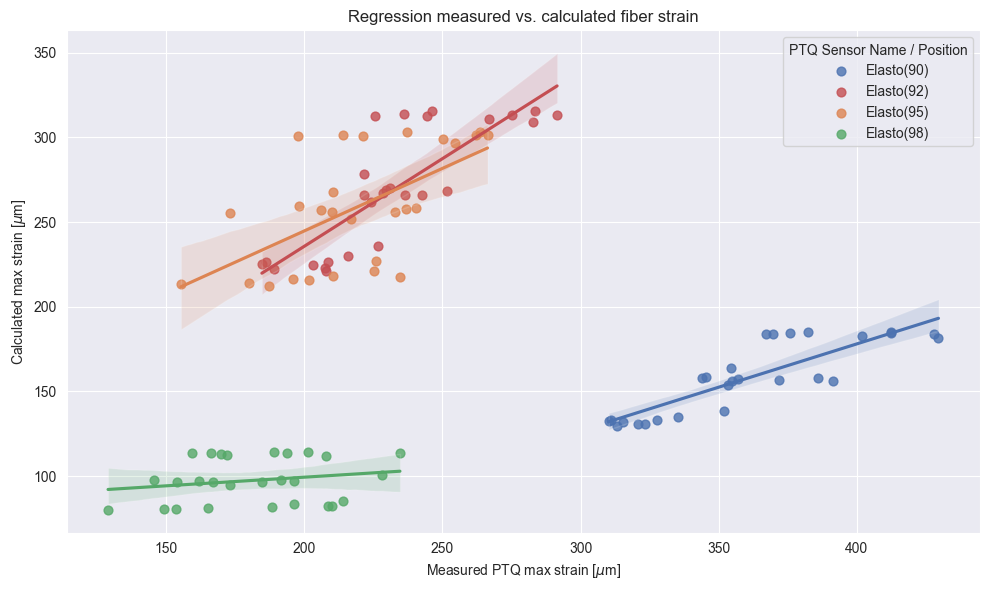

In [331]:
# Grouping DataFrame by 'ptq_sensor_name'
grouped = df.groupby('ptq_sensor_name')

# Perform linear regression and plot for each group
for name, group in grouped:
    # Linear Regression with statsmodels
    X = sm.add_constant(group['ptq_max_elongation'])  # Adding a constant for the intercept
    y = group['calc_max_elongation']
    model = sm.OLS(y, X).fit()
    # Print the summary of the linear regression model
    print(f"Linear Regression Summary for {name}:\n")
    print(model.summary())

# Create regression plots with the correct colors
fig = plt.figure(figsize=(10, 6))

# Draw regression lines and scatter plots for each group
for name, group in df.groupby('ptq_sensor_name'):
    sns.regplot(
        x=group['ptq_max_elongation'],
        y=group['calc_max_elongation'],
        color=sensor_color_dict[name],  # Use the appropriate color from the dictionary
        label=f'{name}',
        scatter_kws={"s": 40}  # Adjusting scatter size
    )

plt.title('Regression measured vs. calculated fiber strain')
plt.xlabel('Measured PTQ max strain [$\mu$m]')
plt.ylabel('Calculated max strain [$\mu$m]')
plt.legend(title='PTQ Sensor Name / Position')
# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="regr_measured_vs_calc_strain", subdir="measured_vs_calc_strain")

In [325]:
df_elongation_mean = df.groupby(['ptq_sensor_name'])[['calc_max_elongation', 'ptq_max_elongation', 'elongation_difference']].mean()
df_elongation_mean

,calc_max_elongation,ptq_max_elongation,elongation_difference
ptq_sensor_name,,,
Elasto(90),158.073110,360.955556,-56.286854
Elasto(92),268.991128,232.140741,16.027369
Elasto(95),258.646471,218.762963,19.033241
Elasto(98),97.483702,181.822222,-45.515530


In [326]:
latex_string = df_elongation_mean.to_latex(index=True, escape=True, float_format="{:0.2f}".format) # column_format="llr", 

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Mittelwerte der Abweichung der rechnerischen von der gemessenen maximalen Faserdehnung gruppiert über Elastometer bzw. Position}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Abweichung_Faserdehnung}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Mittelwerte der Abweichung der rechnerischen von der gemessenen maximalen Faserdehnung gruppiert über Elastometer bzw. Position}
    \begin{tabular}{lrrr}
\toprule
 & calc\_max\_elongation & ptq\_max\_elongation & elongation\_difference \\
ptq_sensor_name &  &  &  \\
\midrule
Elasto(90) & 158.07 & 360.96 & -56.29 \\
Elasto(92) & 268.99 & 232.14 & 16.03 \\
Elasto(95) & 258.65 & 218.76 & 19.03 \\
Elasto(98) & 97.48 & 181.82 & -45.52 \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Abweichung_Faserdehnung}
\end{table}


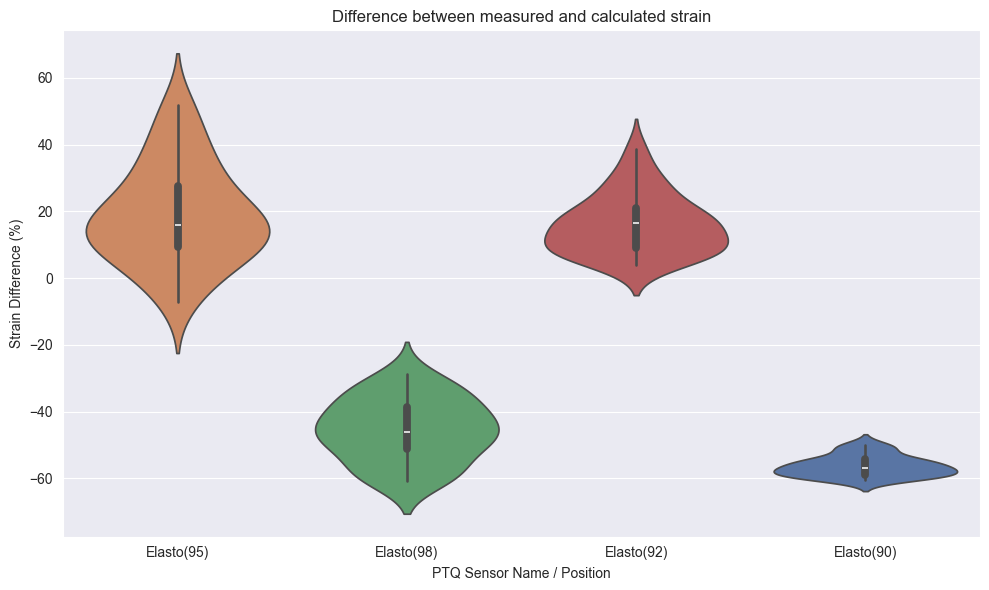

In [322]:
# Create violin plot for elongation_difference grouped by ptq_sensor_name

fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='ptq_sensor_name', y='elongation_difference', hue='ptq_sensor_name', palette=sensor_color_dict, data=df)
plt.title('Difference between measured and calculated strain')
plt.xlabel('PTQ Sensor Name / Position')
plt.ylabel('Strain Difference (%)')
# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="diff_measured_vs_calc_strain", subdir="measured_vs_calc_strain")

In [323]:
df[['calc_max_elongation', 'ptq_max_elongation', 'elongation_difference']].mean()

calc_max_elongation      195.798603
ptq_max_elongation       248.420370
elongation_difference    -16.685443
dtype: float64

### PTQ: Analyse der Dehnungswerte nach Elastometer und Behandlungsvarianten

Plotten der Maximalwerte der Vorspannung für Dehnung und Stauchung. Für jede Messung werden erst die maximalen Werte berechnet und dann getrennt nach Elasto die Verteilung im Boxplot dargestellt.
Auffällig ist Elasto(90) mit den höchsten Dehnungswerten. Dieses Gerät ist am geringfügig dünneren Stämmling angebracht. Die Vorspannung wurde aufgrund der maximalen Messwerte von 429 µm nicht weiter erhöht.

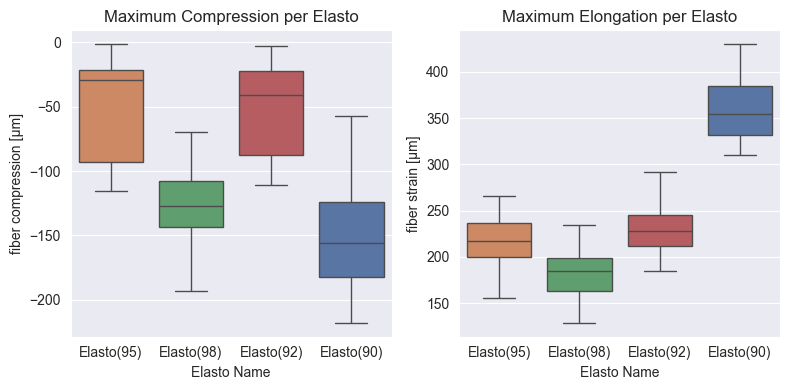

In [276]:
# Erstelle die Subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Boxplot für die minimalen Werte (maximale Compression)
sns.boxplot(data=df, x='ptq_sensor_name', y='ptq_max_compression', hue='ptq_sensor_name', palette=sensor_color_dict, ax=axs[0], legend=False)
axs[0].set_title("Maximum Compression per Elasto")
axs[0].set_xlabel("Elasto Name")
axs[0].set_ylabel("fiber compression [µm]")

# Boxplot für die maximalen Werte (maximale Strain)
sns.boxplot(data=df, x='ptq_sensor_name', y='ptq_max_elongation', hue='ptq_sensor_name', palette=sensor_color_dict, ax=axs[1], legend=False)
axs[1].set_title("Maximum Elongation per Elasto")
axs[1].set_xlabel("Elasto Name")
axs[1].set_ylabel("fiber strain [µm]")

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="elongation_max_per_elasto", subdir="elongation_max_per_elasto")

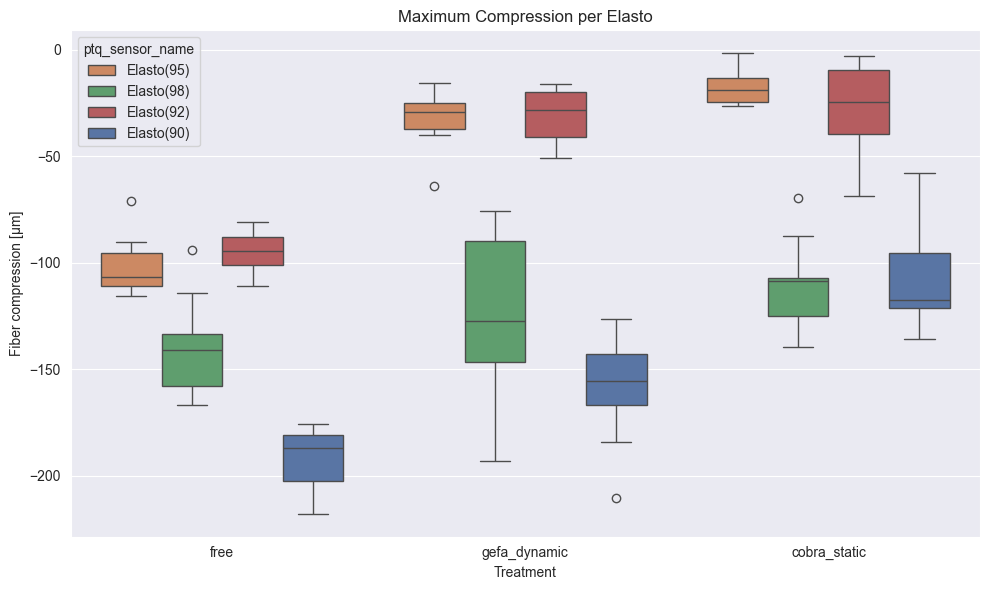

In [277]:
# Erstelle die Subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplot für die minimalen Werte (maximale Compression)
sns.boxplot(data=df, x='treatment', y='ptq_max_compression', hue='ptq_sensor_name', palette=sensor_color_dict, ax=ax)

# Titel und Achsenbeschriftungen setzen
ax.set_title("Maximum Compression per Elasto")
ax.set_xlabel("Treatment")
ax.set_ylabel("Fiber compression [µm]")

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

# Plot speichern
PLOT_MANAGER.save_plot(fig, filename="elongation_max_per_elasto_by_treatment", subdir="elongation_max_per_elasto")

In [278]:
# Lineares Modell mit dem Treatment als Hauptfaktor und ptq_sensor_name als Kontrollvariable
model = smf.ols('ptq_max_compression ~ C(treatment) + C(ptq_sensor_name)', data=df).fit()

# Ergebnisse des Modells anzeigen
print(model.summary())

# Durchführung eines ANOVA-Tests auf die Signifikanz des Einflusses von Treatment
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             OLS Regression Results                            
Dep. Variable:     ptq_max_compression   R-squared:                       0.845
Model:                             OLS   Adj. R-squared:                  0.838
Method:                  Least Squares   F-statistic:                     111.6
Date:                 Wed, 06 Nov 2024   Prob (F-statistic):           9.74e-40
Time:                         22:41:56   Log-Likelihood:                -490.85
No. Observations:                  108   AIC:                             993.7
Df Residuals:                      102   BIC:                             1010.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [279]:
# Tukey HSD Test für die 'treatment' Gruppe
tukey_treatment = mc.pairwise_tukeyhsd(endog=df['ptq_max_compression'],
                                    groups=df['treatment'],
                                    alpha=0.05)
print(tukey_treatment)

# Tukey HSD Test für die 'ptq_sensor_name' Gruppe
tukey_sensor = mc.pairwise_tukeyhsd(endog=df['ptq_max_compression'],
                                 groups=df['ptq_sensor_name'],
                                 alpha=0.05)
print(tukey_sensor)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
cobra_static         free -66.7972    0.0 -95.6656 -37.9288   True
cobra_static gefa_dynamic  -20.925 0.2013 -49.7934   7.9434  False
        free gefa_dynamic  45.8722 0.0008  17.0038  74.7406   True
------------------------------------------------------------------
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj    lower    upper   reject
---------------------------------------------------------------
Elasto(90) Elasto(92)    102.4    0.0   76.3167 128.4833   True
Elasto(90) Elasto(95) 102.8852    0.0   76.8019 128.9684   True
Elasto(90) Elasto(98)  28.0741 0.0297    1.9908  54.1573   True
Elasto(92) Elasto(95)   0.4852    1.0  -25.5981  26.5684  False
Elasto(92) Elasto(98) -74.3259    0.0 -100.4092 -48.2427   True
Elasto(95) Elasto(9

### PTQ: Anlayse der Schwingungensparameter

In [280]:

variables = [
    'ptq_m_amplitude',
    'ptq_m_amplitude_2',
    'ptq_initial_amplitude',
    'ptq_damping_coeff',
    'ptq_angular_frequency',
    'ptq_pearson_r',
    'ptq_max_compression'
]
#df.head()

#### Analyse der Effekte der Sensoren bzw. Positionen

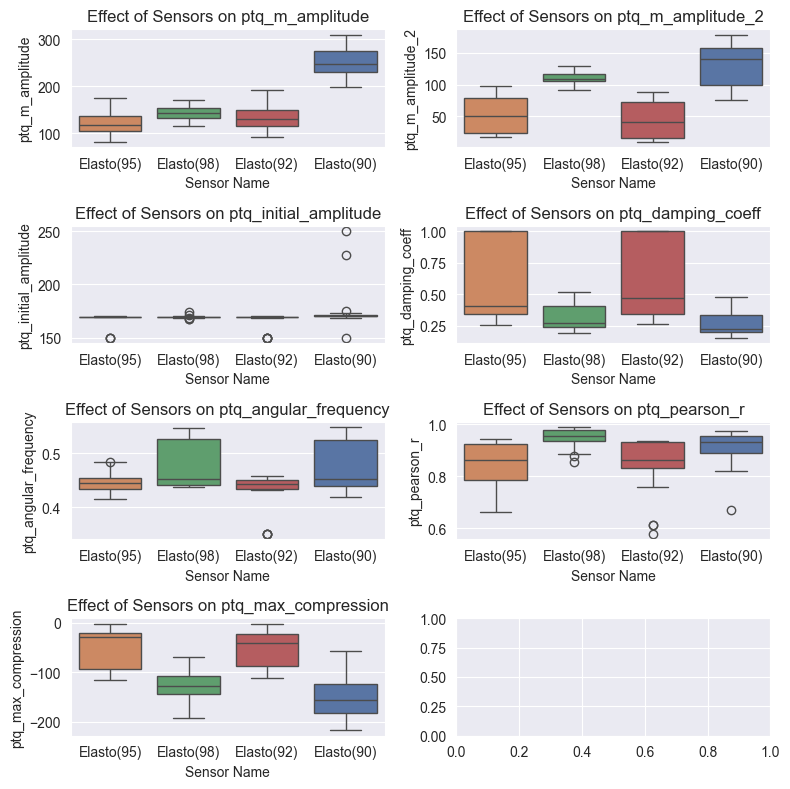

In [281]:
# Boxplots erstellen für die Sensoren
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sns.boxplot(ax=axes[i], x='ptq_sensor_name', y=variable, data=df, palette=sensor_color_dict, hue='ptq_sensor_name', dodge=False, legend=False)
    axes[i].set_title(f'Effect of Sensors on {variable}')
    axes[i].set_xlabel('Sensor Name')
    axes[i].set_ylabel(variable)

plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_for_sensors", subdir="combined")

In [282]:
# ANCOVA
models = {}
summaries = {}

for variable in variables:
    model = smf.ols(f"{variable} ~ treatment + C(ptq_sensor_name)", data=df).fit()
    models[variable] = model
    summaries[variable] = model.summary() # as_latex() # ggf. auskommentieren für latex

# Allgemeine Anzeige- und Druckfunktionen
def print_summaries(summaries):
    for variable, summary in summaries.items():
        print(f"Summary für {variable}:")
        print(summary)
        print("\n")

print_summaries(summaries)

Summary für ptq_m_amplitude:
                            OLS Regression Results                            
Dep. Variable:        ptq_m_amplitude   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     208.1
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           7.66e-52
Time:                        22:41:59   Log-Likelihood:                -459.42
No. Observations:                 108   AIC:                             930.8
Df Residuals:                     102   BIC:                             946.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

Schritt 2: Durchführung von Post-hoc-Tests

Festzustellen welche paarweisen Unterschiede zwischen den Treatments signifikant sind.

In [283]:
# Funktion zur Durchführung der Post-Hoc Tests und zur Extraktion der Signifikanzergebnisse
def perform_tukey_test(df: pd.DataFrame, variables: list, group_col: str):
    tukey_results = {}
    for variable in variables:
        comp = mc.MultiComparison(df[variable], df[group_col])
        tukey = comp.tukeyhsd()
        tukey_results[variable] = tukey
    return tukey_results

# Tukey HSD Test Ergebnisse erhalten
tukey_results = perform_tukey_test(df, variables, 'treatment')

print_summaries(tukey_results)

Summary für ptq_m_amplitude:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
cobra_static         free  43.8208 0.0028  13.0686 74.5731   True
cobra_static gefa_dynamic  21.8458 0.2142  -8.9064 52.5981  False
        free gefa_dynamic  -21.975 0.2104 -52.7273  8.7773  False
-----------------------------------------------------------------


Summary für ptq_m_amplitude_2:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
cobra_static         free  49.2444    0.0  27.0088   71.48   True
cobra_static gefa_dynamic  27.4736 0.0113    5.238 49.7092   True
        free gefa_dynamic -21.7708 0.0563 -44.0064  0.4648  False
-----------------------------------------------------------------


Summary für 

In [284]:
# Q-Q-Plots der Residuen für alle Modelle
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sm.qqplot(models[variable].resid, line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {variable} Residuals')
plt.tight_layout()
#plt.show()
PLOT_MANAGER.save_plot(fig, filename="qq_plot_residuen", subdir="combined")

In [285]:
# Homoskedastizität prüfen (Residuals-vs-Fitted-Plot)
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    axes[i].scatter(models[variable].fittedvalues, models[variable].resid)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f'Residuals vs Fitted for {variable}')
    axes[i].set_xlabel('Fitted values')
    axes[i].set_ylabel('Residuals')
plt.tight_layout()
#plt.show()
PLOT_MANAGER.save_plot(fig, filename="residuals_vs_fitted_plot", subdir="combined")

In [286]:
# Funktion zur Berechnung von Eta-Quadrat für alle Modelle
def eta_squared(anova_model):
    aov_table = sm.stats.anova_lm(anova_model, typ=2)
    aov_table['eta_sq'] = aov_table[:-1]['sum_sq'] / sum(aov_table['sum_sq'])
    return aov_table['eta_sq']

# Berechnung von Eta-Quadrat für alle Modelle
eta_sq_results = {}

for variable in variables:
    eta_sq_results[variable] = eta_squared(models[variable])

# Ergebnisse anzeigen
print(eta_sq_results)

{'ptq_m_amplitude': treatment             0.098532
C(ptq_sensor_name)    0.812180
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_m_amplitude_2': treatment             0.209610
C(ptq_sensor_name)    0.696422
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_initial_amplitude': treatment             0.041745
C(ptq_sensor_name)    0.097354
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_damping_coeff': treatment             0.521945
C(ptq_sensor_name)    0.300667
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_angular_frequency': treatment             0.227567
C(ptq_sensor_name)    0.226731
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_pearson_r': treatment             0.298676
C(ptq_sensor_name)    0.264794
Residual                   NaN
Name: eta_sq, dtype: float64, 'ptq_max_compression': treatment             0.231712
C(ptq_sensor_name)    0.613740
Residual                   NaN
Name: eta_sq, dty

#### Vorhergesagte Werte extrahieren und Boxplots für die Sensoren erstellen

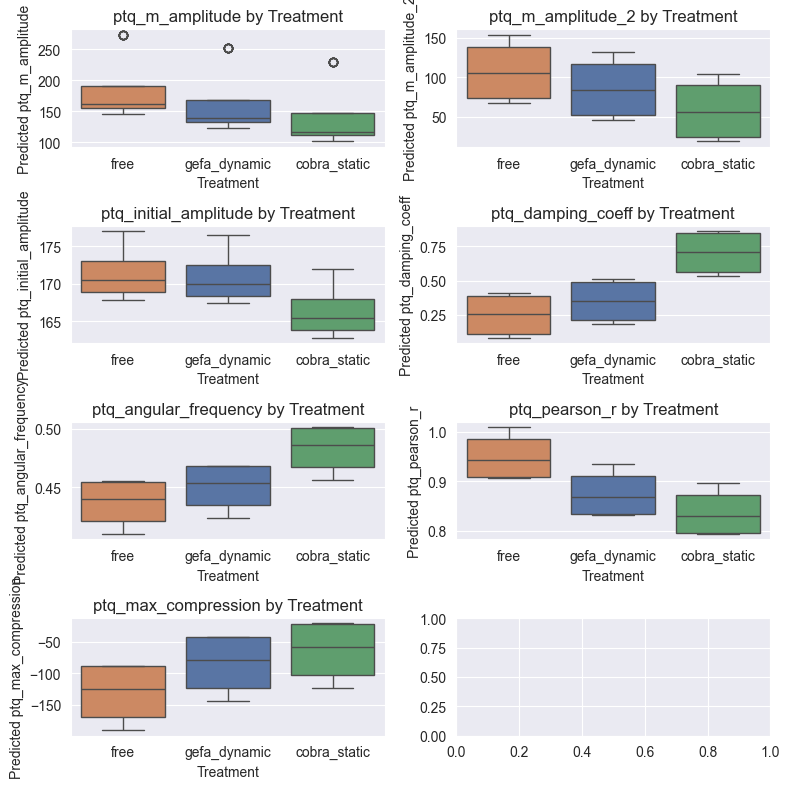

In [287]:
# Vorhergesagte Werte aus den Modellen extrahieren
for variable in variables:
    df[f'predicted_{variable}'] = models[variable].fittedvalues

# Boxplots erstellen mit den vorhergesagten Werten
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sns.boxplot(ax=axes[i], x='treatment', y=f'predicted_{variable}', data=df, palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    axes[i].set_title(f'{variable} by Treatment')
    axes[i].set_xlabel('Treatment')
    axes[i].set_ylabel(f'Predicted {variable}')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="predicted_effect_for_treatment", subdir="combined")

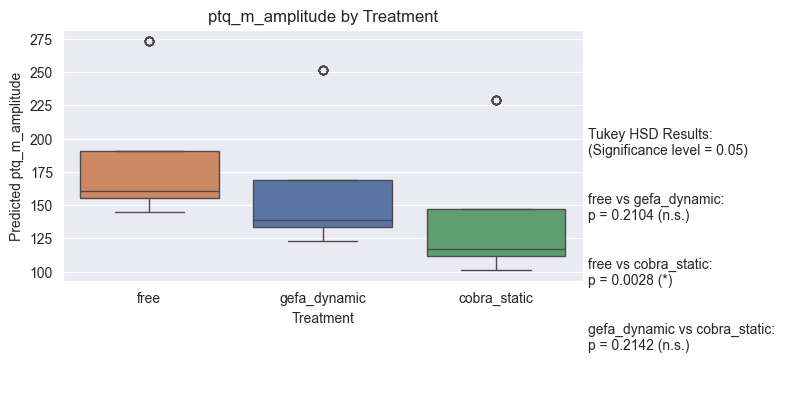

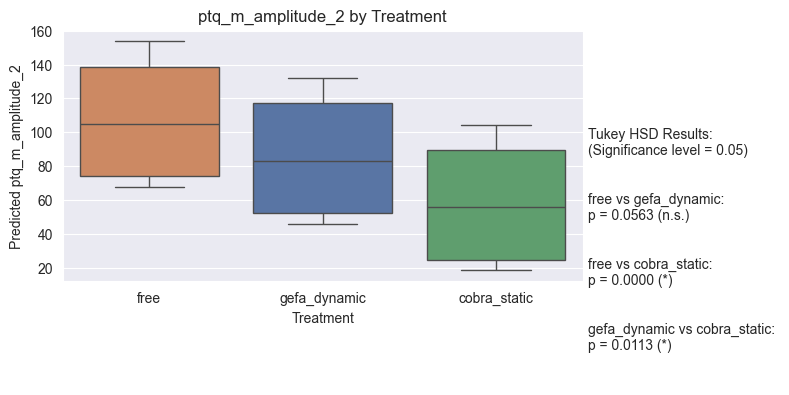

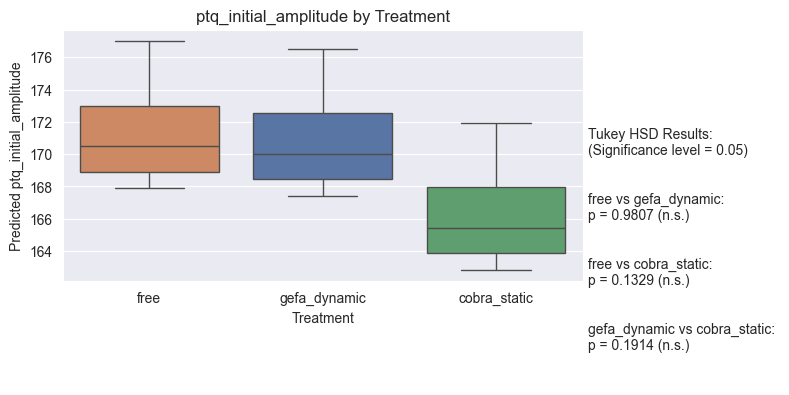

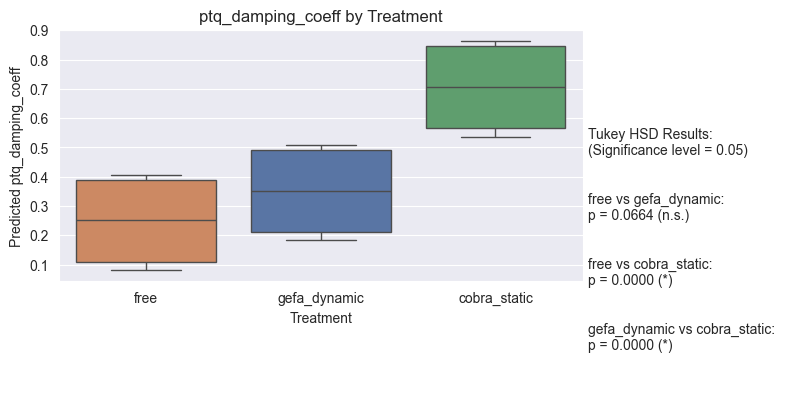

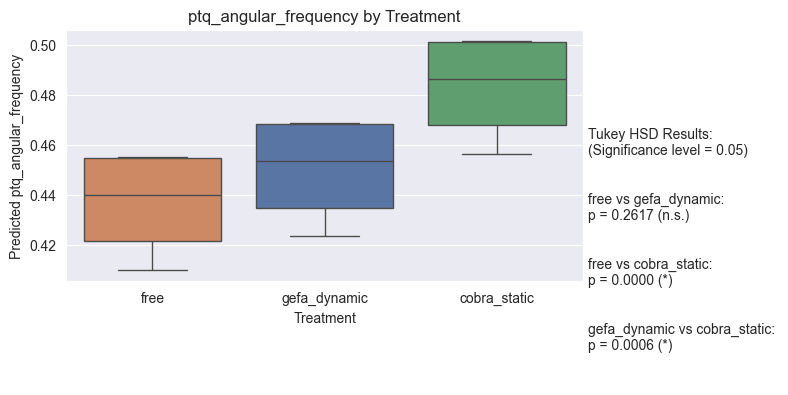

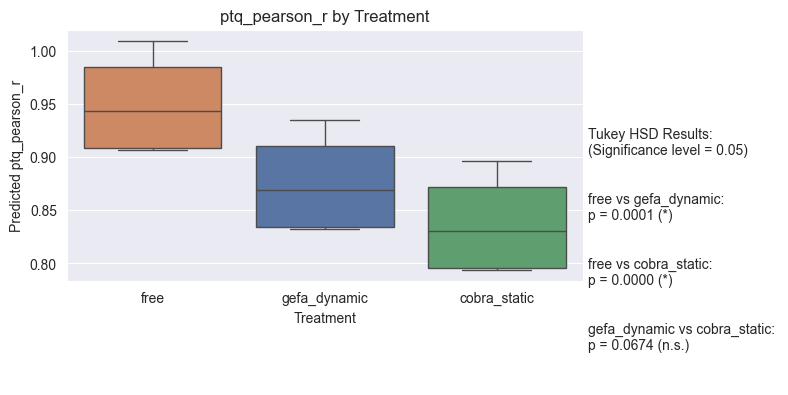

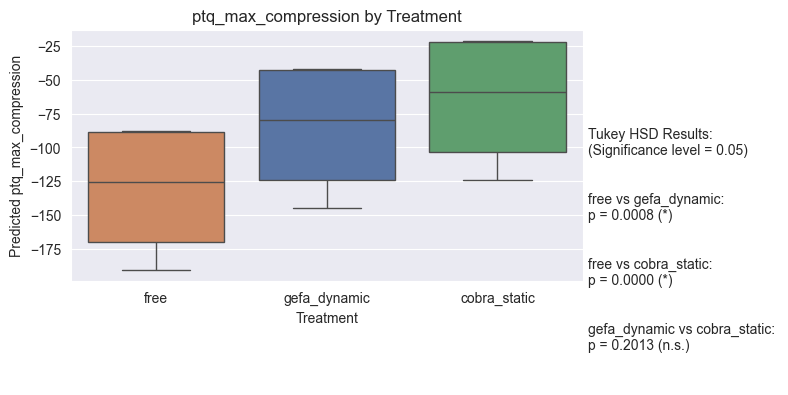

In [288]:
def annotate_tukey(ax, tukey_result, significance_level=0.05):
    """
    Fügt eine Textbox mit den Tukey-Test-Ergebnissen und dem festgelegten Signifikanzniveau in den Plot ein.
    
    Parameters:
    ax (matplotlib.axes): Die Achse, auf der der Plot gezeichnet wird.
    tukey_result (TukeyHSDResults): Die Ergebnisse des Tukey HSD Tests.
    significance_level (float): Das Signifikanzniveau, standardmäßig 0.05.
    """
    # Definiere die gewünschte Reihenfolge der Vergleiche
    comparisons_order = [('free', 'gefa_dynamic'), ('free', 'cobra_static'), ('gefa_dynamic', 'cobra_static')]

    # Text für die Annotation zusammenstellen
    text_str = f"Tukey HSD Results: \n(Significance level = {significance_level:.2f})\n\n"
    
    # Durchlaufe die gewünschte Vergleichsreihenfolge
    for group1, group2 in comparisons_order:
        # Filtere die korrekte Paarung aus den Tukey-Ergebnissen
        for i in range(len(tukey_result._results_table.data[1:])):
            pair = tukey_result._results_table.data[i + 1]
            if (pair[0] == group1 and pair[1] == group2) or (pair[0] == group2 and pair[1] == group1):
                p_value = tukey_result.pvalues[i]
                significance = "*" if p_value < significance_level else "n.s."
                text_str += f"\n{group1} vs {group2}: \np = {p_value:.4f} ({significance})\n\n"
    
    # Textbox am Rand des Plots hinzufügen
    ax.annotate(text_str, xy=(1.01, 0.1), xycoords='axes fraction', va='center', ha='left')

# Einzelne Plots für jede Variable erstellen und speichern
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Boxplot für die aktuelle Variable
    sns.boxplot(ax=ax, x='treatment', y=f'predicted_{variable}', data=df, 
                palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    
    # Tukey-Test für die aktuelle Variable
    tukey_result = tukey_results[variable]
    
    # Tukey-Ergebnisse annotieren
    annotate_tukey(ax, tukey_result)
    
    ax.set_title(f'{variable} by Treatment')
    ax.set_xlabel('Treatment')
    ax.set_ylabel(f'Predicted {variable}')
    
    plt.tight_layout()
    plt.show()

    # Plot speichern
    plot_filename = f"{variable}_effect_for_treatment"
    PLOT_MANAGER.save_plot(fig, filename=plot_filename, subdir="osc_variables_box")


In [289]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_treatment_describe = (df.drop(['id', 'ptq_sensor_name'], axis=1)
                         .groupby('treatment', observed=True)
                         .describe())

df_treatment_describe = df_treatment_describe.reset_index()
df_treatment_describe.round(2)

treatment ptq_m_amplitude                                         \
                          count    mean    std     min     25%     50%   
0          free            36.0  184.97  55.17  132.55  147.07  160.65   
1  gefa_dynamic            36.0  163.00  56.99  105.30  126.18  141.38   
2  cobra_static            36.0  141.15  52.38   81.90  103.86  123.00   

                  ptq_m_amplitude_2  ... predicted_ptq_pearson_r        \
      75%     max             count  ...                     75%   max   
0  204.02  309.85              36.0  ...                    0.98  1.01   
1  179.12  286.40              36.0  ...                    0.91  0.93   
2  158.32  253.55              36.0  ...                    0.87  0.90   

  predicted_ptq_max_compression                                                \
                          count    mean    std     min     25%     50%    75%   
0                          36.0 -132.54  46.05 -190.88 -169.82 -125.64 -88.36   
1                          36.0  -86.67  46.05 -145.01 -123.95  -79.77 -42.49   
2                          36.0  -65.74  46.05 -124.08 -103.03  -58.84 -21.56   

          
     max  
0 -87.99  
1 -42.12  
2 -21.20  

[3 rows x 201 columns]

In [290]:
#df.columns

In [291]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_sensor = (df.drop(['id', 'release_force_target', 'ls3_rope_release', 'ls3_cable_max'], axis=1).
             groupby(['treatment', 'ptq_sensor_name'], observed=True).
             mean())  #.T
#df_sensor.round(4)

TypeError: category dtype does not support aggregation 'mean'

In [ ]:
# Gruppieren des DataFrames und Anwenden von mean für ptq_sensor_name 
df_id = ((df.drop(['ptq_sensor_name'], axis=1)
          .groupby(['treatment', 'id'], observed=True)
          .mean())
         .reset_index())

df_id.round(4).head()

### Korrelation übergreifend zwischen LS3 und PTQ

In [ ]:
# Auswahl der neuen Spaltennamen für die Korrelationsmatrix
columns_corr = ['ptq_m_amplitude',
                'ptq_m_amplitude_2',
                'ptq_initial_amplitude',
                'ptq_damping_coeff',
                'ptq_angular_frequency',
                'ptq_y_shift',
                'ptq_pearson_r',
                #'ptq_nrmse',
                'ptq_nmae',
                'release_force_target',
                'ls3_rope_release',
                'ls3_cable_max']
df_corr = df_id.copy()[columns_corr]

# Berechnung der Korrelationsmatrix
correlation_matrix = df_corr.corr()

# Visualisierung der Korrelationsmatrix mit Seaborn
fig1, ax = plt.subplots(figsize=(8, 8))  # Anpassen der Größe der Grafik
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, annot_kws={'size': 10})

# Titel und Schriftgrößen anpassen
#plt.title('Correlation Matrix for LS3 and PTQ', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig1, filename="correlation_matrix", subdir="combined")

In [ ]:
# ANOVA für 'ls3_rope_release'
model_rope_release = smf.ols('ls3_rope_release ~ treatment', data=df_id).fit()
anova_rope_release = sm.stats.anova_lm(model_rope_release, typ=2)

# ANOVA für 'ls3_cable_max'
model_cable_max = smf.ols('ls3_cable_max ~ treatment', data=df_id).fit()
anova_cable_max = sm.stats.anova_lm(model_cable_max, typ=2)

# Zusammenfassungen der Modelle
summary_rope_release = model_rope_release.summary()
summary_cable_max = model_cable_max.summary()
# Zusammenfassungen der Modelle
summary_rope_release_latex = model_rope_release.summary().as_latex()
summary_cable_max_latex = model_cable_max.summary().as_latex()

#print(summary_rope_release_latex)
#print(summary_cable_max_latex)

anova_rope_release, summary_rope_release, anova_cable_max, summary_cable_max

In [ ]:
# Funktion zur Erstellung des Text-Strings für die statistischen Parameter
def annotate_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    text_str = f"R = {r_value:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}\np-value = {p_value:.2e}\nStd Err = {std_err:.2f}"
    return text_str


# Funktion zur Durchführung des ANOVA-Tests und Berechnung der Effektstärke (Eta Squared)
def perform_anova_and_effect_size(df: pd.DataFrame, variable: str, treatments: List[str]) -> str:
    groups = [df[df['treatment'] == treatment][variable].dropna() for treatment in treatments]
    f_stat, p_value = f_oneway(*groups)

    # Berechnung der Effektstärke (Eta Squared)
    n = sum([len(g) for g in groups])
    ss_total = sum([(x - df[variable].mean()) ** 2 for g in groups for x in g])
    eta_squared = f_stat * len(groups) / (f_stat * len(groups) + (n - len(groups)))

    # Überprüfung der Signifikanz
    significance = "*" if p_value < 0.05 else ""

    return f"{variable}: {significance}\nF-statistic = {f_stat:.2f}\np-value = {p_value:.2e}\nEta Squared = {eta_squared:.2f}"

In [ ]:
fig2, ax1 = plt.subplots(figsize=(8, 5))
sns.regplot(x='release_force_target', y='ls3_rope_release', data=df_id, ax=ax1, color='b', ci=95)
ax2 = ax1.twinx()
ax2.axis('off')
stats_text = annotate_stats(df_id['release_force_target'], df_id['ls3_rope_release'])
ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
#ax1.set_title('Correlation Between Target and Actual Release Forces"')
ax1.set_xlabel('Release Force Target [kN]')
ax1.set_ylabel('Release Force [kN]')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig2, filename=f"release_force_target_vs_ls3_rope_release", subdir="combined")

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ls3_cable_max'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ls3_cable_max', data=subset, ax=ax1, color=color, label=treatment, ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ls3_cable_max'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Peak Cable Force')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Peak Force in Cable [kN]')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"release_force_vs_ls3_cable_max", subdir="combined")

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude", subdir="combined")


In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude_2'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude_2', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude_2'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude 2')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude 2 [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude_2", subdir="combined")

In [ ]:
# Funktion zur Erstellung von Boxplots
def create_boxplot(df: pd.DataFrame, variable: str, group_by: str, ax: plt.Axes, color_dict: Dict[str, str], perform_stats: bool) -> None:
    valid_df = df.dropna(subset=[variable])
    sns.boxplot(x=group_by, y=variable, hue=group_by, data=valid_df, ax=ax, palette=color_dict, dodge=False)
    ax2 = ax.twinx()
    ax2.axis('off')
    if perform_stats:
        stats_text = perform_anova_and_effect_size(valid_df, variable, valid_df[group_by].unique())
        ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
    ax.set_title(f'Einfluss von {group_by} auf {variable}')
    ax.set_xlabel(group_by)
    ax.set_ylabel(variable)

# Funktion zur Erstellung kombinierter Plots
def create_combined_plot(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], num_columns: int = 3, perform_stats: bool = False) -> None:
    num_rows = len(columns) // num_columns + (len(columns) % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(columns):
        create_boxplot(df, variable, group_by, axes[idx], color_dict, perform_stats)

    plt.tight_layout()
    plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"combined_plot_{group_by}", subdir="combined")

# Funktion zur Erstellung einzelner Plots
def create_individual_plots(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], perform_stats: bool = False) -> None:
    for variable in columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        create_boxplot(df, variable, group_by, ax, color_dict, perform_stats)
        plt.tight_layout()
        #plt.show()
        PLOT_MANAGER.save_plot(fig, filename=f"{group_by}_{variable}", subdir="individual_plots")

In [ ]:
columns = ['ptq_m_amplitude',
           'ptq_m_amplitude_2',
           'ptq_initial_amplitude',
           'ptq_damping_coeff',
           'ptq_angular_frequency',
           'ptq_y_shift',
           'ptq_pearson_r',
           #'ptq_nrmse',
           #'ptq_nmae',
           #'release_force_target',
           'ls3_rope_release',
           'ls3_cable_max'
           ]

# Beispiel: Erstellen von Plots gruppiert nach 'treatment'
create_combined_plot(df, columns, 'treatment', treatment_color_dict, perform_stats=True)
create_individual_plots(df, columns, 'treatment', treatment_color_dict, perform_stats=True)

In [ ]:
# Beispiel: Erstellen von Plots gruppiert nach 'ptq_sensor_name'
columns = ['ptq_m_amplitude', 'ptq_m_amplitude_2', 'ptq_initial_amplitude', 'ptq_damping_coeff', 'ptq_angular_frequency', 'ptq_pearson_r']

create_combined_plot(df, columns, 'ptq_sensor_name', sensor_color_dict)
create_individual_plots(df, columns, 'ptq_sensor_name', sensor_color_dict)